<a href="https://colab.research.google.com/github/avsolatorio/REaLTabFormer-Experiments/blob/main/Relational_REaLTabFormer_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !ln -s /content/drive/MyDrive/REaLTabFormer/REaLTabFormer-Experiments /content/REaLTabFormer-Experiments

In [4]:
# !pip install matplotlib==3.1.3 &> /dev/null

In [1]:
import json
import os
import warnings

warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import torch

from pathlib import Path

In [178]:
"""SDMetrics utils to be used across all the project."""

import warnings
from collections import Counter
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


def nested_attrs_meta(nested):
    """Metaclass factory that defines a Metaclass with a dynamic attribute name."""

    class Metaclass(type):
        """Metaclass which pulls the attributes from a nested object using properties."""

        def __getattr__(cls, attr):
            """If cls does not have the attribute, try to get it from the nested object."""
            nested_obj = getattr(cls, nested)
            if hasattr(nested_obj, attr):
                return getattr(nested_obj, attr)

            raise AttributeError(f"type object '{cls.__name__}' has no attribute '{attr}'")

        @property
        def name(cls):
            return getattr(cls, nested).name

        @property
        def goal(cls):
            return getattr(cls, nested).goal

        @property
        def max_value(cls):
            return getattr(cls, nested).max_value

        @property
        def min_value(cls):
            return getattr(cls, nested).min_value

    return Metaclass


def get_frequencies(real, synthetic):
    """Get percentual frequencies for each possible real categorical value.

    Given two iterators containing categorical data, this transforms it into
    observed/expected frequencies which can be used for statistical tests. It
    adds a regularization term to handle cases where the synthetic data contains
    values that don't exist in the real data.

    Args:
        real (list):
            A list of hashable objects.
        synthetic (list):
            A list of hashable objects.

    Yields:
        tuble[list, list]:
            The observed and expected frequencies (as a percent).
    """
    f_obs, f_exp = [], []
    real, synthetic = Counter(real), Counter(synthetic)
    for value in synthetic:
        if value not in real:
            warnings.warn(f'Unexpected value {value} in synthetic data.')
            real[value] += 1e-6  # Regularization to prevent NaN.

    for value in real:
        f_obs.append(synthetic[value] / sum(synthetic.values()))  # noqa: PD011
        f_exp.append(real[value] / sum(real.values()))  # noqa: PD011

    return f_obs, f_exp


def get_cardinality_distribution(parent_column, child_column):
    """Compute the cardinality distribution of the (parent, child) pairing.

    Args:
        parent_column (pandas.Series):
            The parent column.
        child_column (pandas.Series):
            The child column.

    Returns:
        pandas.Series:
            The cardinality distribution.
    """
    child_df = pd.DataFrame({'child_counts': child_column.value_counts()})
    cardinality_df = pd.DataFrame({'parent': parent_column}).join(
        child_df, on='parent').fillna(0)

    return cardinality_df['child_counts']


def is_datetime(data):
    """Determine if the input is a datetime type or not.

    Args:
        data (pandas.DataFrame, int or datetime):
            Input to evaluate.

    Returns:
        bool:
            True if the input is a datetime type, False if not.
    """
    return (
        pd.api.types.is_datetime64_any_dtype(data)
        or isinstance(data, pd.Timestamp)
        or isinstance(data, datetime)
    )


class HyperTransformer():
    """HyperTransformer class.

    The ``HyperTransformer`` class contains a set of transforms to transform one or
    more columns based on each column's data type.
    """

    column_transforms = {}
    column_kind = {}

    def fit(self, data):
        """Fit the HyperTransformer to the given data.

        Args:
            data (pandas.DataFrame):
                The data to transform.
        """
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)

        for field in data:
            kind = data[field].dropna().infer_objects().dtype.kind
            self.column_kind[field] = kind

            if kind == 'i' or kind == 'f':
                # Numerical column.
                self.column_transforms[field] = {'mean': data[field].mean()}
            elif kind == 'b':
                # Boolean column.
                numeric = pd.to_numeric(data[field], errors='coerce').astype(float)
                self.column_transforms[field] = {'mode': numeric.mode().iloc[0]}
            elif kind == 'O':
                # Categorical column.
                col_data = pd.DataFrame({'field': data[field]})
                enc = OneHotEncoder(handle_unknown="ignore")
                enc.fit(col_data)
                self.column_transforms[field] = {'one_hot_encoder': enc}
            elif kind == 'M':
                # Datetime column.
                nulls = data[field].isna()
                integers = pd.to_numeric(
                    data[field], errors='coerce').to_numpy().astype(np.float64)
                integers[nulls] = np.nan
                self.column_transforms[field] = {'mean': pd.Series(integers).mean()}

    def transform(self, data):
        """Transform the given data based on the data type of each column.

        Args:
            data (pandas.DataFrame):
                The data to transform.

        Returns:
            pandas.DataFrame:
                The transformed data.
        """
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)

        for field in data:
            transform_info = self.column_transforms[field]

            kind = self.column_kind[field]
            if kind == 'i' or kind == 'f':
                # Numerical column.
                data[field] = data[field].fillna(transform_info['mean'])
            elif kind == 'b':
                # Boolean column.
                data[field] = pd.to_numeric(data[field], errors='coerce').astype(float)
                data[field] = data[field].fillna(transform_info['mode'])
            elif kind == 'O':
                # Categorical column.
                col_data = pd.DataFrame({'field': data[field]})
                out = transform_info['one_hot_encoder'].transform(col_data).toarray()
                transformed = pd.DataFrame(
                    out, columns=[f'value{i}' for i in range(np.shape(out)[1])])
                data = data.drop(columns=[field])
                data = pd.concat([data, transformed.set_index(data.index)], axis=1)
            elif kind == 'M':
                # Datetime column.
                nulls = data[field].isna()
                integers = pd.to_numeric(
                    data[field], errors='coerce').to_numpy().astype(np.float64)
                integers[nulls] = np.nan
                data[field] = pd.Series(integers, index=data.index)
                data[field] = data[field].fillna(transform_info['mean'])

        return data

    def fit_transform(self, data):
        """Fit and transform the given data based on the data type of each column.

        Args:
            data (pandas.DataFrame):
                The data to transform.

        Returns:
            pandas.DataFrame:
                The transformed data.
        """
        self.fit(data)
        return self.transform(data)


def get_columns_from_metadata(metadata):
    """Get the column info from a metadata dict.

    Args:
        metadata (dict):
            The metadata dict.

    Returns:
        dict:
            The columns metadata.
    """
    if 'fields' in metadata:
        return metadata['fields']

    if 'columns' in metadata:
        return metadata['columns']

    return []


def get_type_from_column_meta(column_metadata):
    """Get the type of a given column from the column metadata.

    Args:
        column_metadata (dict):
            The column metadata.

    Returns:
        string:
            The column type.
    """
    if 'type' in column_metadata:
        return column_metadata['type']

    if 'sdtype' in column_metadata:
        return column_metadata['sdtype']

    return ''


def get_alternate_keys(metadata):
    """Get the alternate keys from a metadata dict.

    Args:
        metadata (dict):
            The metadata dict.

    Returns:
        list:
            The list of alternate keys.
    """
    alternate_keys = []
    for alternate_key in metadata.get('alternate_keys', []):
        if type(alternate_key) is list:
            alternate_keys.extend(alternate_key)
        else:
            alternate_keys.append(alternate_key)

    return alternate_keys

In [179]:
"""Base class for Machine Learning Detection metrics for single table datasets."""

import logging

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from sdmetrics.errors import IncomputableMetricError
from sdmetrics.goal import Goal
from sdmetrics.single_table.base import SingleTableMetric
# from sdmetrics.utils import HyperTransformer: Use the fixed version above with OneHotEncoder variable handle_unknown="ignore"

LOGGER = logging.getLogger(__name__)


class DetectionMetric(SingleTableMetric):
    """Base class for Machine Learning Detection based metrics on single tables.

    These metrics build a Machine Learning Classifier that learns to tell the synthetic
    data apart from the real data, which later on is evaluated using Cross Validation.

    The output of the metric is one minus the average ROC AUC score obtained.

    Attributes:
        name (str):
            Name to use when reports about this metric are printed.
        goal (sdmetrics.goal.Goal):
            The goal of this metric.
        min_value (Union[float, tuple[float]]):
            Minimum value or values that this metric can take.
        max_value (Union[float, tuple[float]]):
            Maximum value or values that this metric can take.
    """

    name = 'SingleTable Detection'
    goal = Goal.MAXIMIZE
    min_value = 0.0
    max_value = 1.0

    @staticmethod
    def _fit_predict(X_train, y_train, X_test):
        """Fit a classifier and then use it to predict."""
        raise NotImplementedError()

    @classmethod
    def compute(cls, real_data, synthetic_data, metadata=None):
        """Compute this metric.

        This builds a Machine Learning Classifier that learns to tell the synthetic
        data apart from the real data, which later on is evaluated using Cross Validation.

        The output of the metric is one minus the average ROC AUC score obtained.

        Args:
            real_data (Union[numpy.ndarray, pandas.DataFrame]):
                The values from the real dataset.
            synthetic_data (Union[numpy.ndarray, pandas.DataFrame]):
                The values from the synthetic dataset.
            metadata (dict):
                Table metadata dict. If not passed, it is build based on the
                real_data fields and dtypes.

        Returns:
            float:
                One minus the ROC AUC Cross Validation Score obtained by the classifier.
        """
        real_data, synthetic_data, metadata = cls._validate_inputs(
            real_data, synthetic_data, metadata)

        if metadata is not None and 'primary_key' in metadata:
            transformed_real_data = real_data.drop(metadata['primary_key'], axis=1)
            transformed_synthetic_data = synthetic_data.drop(metadata['primary_key'], axis=1)

        else:
            transformed_real_data = real_data
            transformed_synthetic_data = synthetic_data

        ht = HyperTransformer()
        transformed_real_data = ht.fit_transform(transformed_real_data).to_numpy()
        transformed_synthetic_data = ht.transform(transformed_synthetic_data).to_numpy()
        X = np.concatenate([transformed_real_data, transformed_synthetic_data])
        y = np.hstack([
            np.ones(len(transformed_real_data)), np.zeros(len(transformed_synthetic_data))
        ])
        if np.isin(X, [np.inf, -np.inf]).any():
            X[np.isin(X, [np.inf, -np.inf])] = np.nan

        try:
            scores = []
            kf = StratifiedKFold(n_splits=3, shuffle=True)
            for train_index, test_index in kf.split(X, y):
                y_pred = cls._fit_predict(X[train_index], y[train_index], X[test_index])
                roc_auc = roc_auc_score(y[test_index], y_pred)

                scores.append(max(0.5, roc_auc) * 2 - 1)

            return 1 - np.mean(scores)
        except ValueError as err:
            raise IncomputableMetricError(f'DetectionMetric: Unable to be fit with error {err}')

    @classmethod
    def normalize(cls, raw_score):
        """Return the `raw_score` as is, since it is already normalized.

        Args:
            raw_score (float):
                The value of the metric from `compute`.

        Returns:
            float:
                Simply returns `raw_score`.
        """
        return super().normalize(raw_score)

In [180]:
"""scikit-learn based DetectionMetrics for single table datasets."""
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC

# from sdmetrics.single_table.detection.base import DetectionMetric: Use the fixed version above with HyperTransformer using OneHotEncoder variable handle_unknown="ignore"


class ScikitLearnClassifierDetectionMetric(DetectionMetric):
    """Base class for Detection metrics build using Scikit Learn Classifiers.

    The base class for these metrics makes a prediction using a scikit-learn
    pipeline which contains a SimpleImputer, a RobustScaler and finally
    the classifier, which is defined in the subclasses.
    """

    name = 'Scikit-Learn Detection'

    @staticmethod
    def _get_classifier():
        """Build and return an instance of a scikit-learn Classifier."""
        raise NotImplementedError()

    @classmethod
    def _fit_predict(cls, X_train, y_train, X_test):
        """Fit a pipeline to the training data and then use it to make prediction on test data."""
        model = Pipeline([
            ('imputer', SimpleImputer()),
            ('scalar', RobustScaler()),
            ('classifier', cls._get_classifier()),
        ])
        model.fit(X_train, y_train)

        return model.predict_proba(X_test)[:, 1]

In [181]:
import sdv.metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

class LogisticDetection(ScikitLearnClassifierDetectionMetric):
    """ScikitLearnClassifierDetectionMetric based on a LogisticRegression.

    This metric builds a LogisticRegression Classifier that learns to tell the synthetic
    data apart from the real data, which later on is evaluated using Cross Validation.

    The output of the metric is one minus the average ROC AUC score obtained.
    """

    name = 'LogisticRegression Detection'

    @staticmethod
    def _get_classifier():
        return LogisticRegression(solver='lbfgs', max_iter=500)


class RandomForestDetection(ScikitLearnClassifierDetectionMetric):
    """ScikitLearnClassifierDetectionMetric based on a RandomForest.

    This metric builds a RandomForest Classifier that learns to tell the synthetic
    data apart from the real data, which later on is evaluated using Cross Validation.

    The output of the metric is one minus the average ROC AUC score obtained.
    """

    name = 'RandomForest Detection'

    @staticmethod
    def _get_classifier():
        return RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=25, oob_score=False)


# m = sdv.metrics.relational.LogisticDetection(lm)

def report_logistic(real_in, real_out, rtf_in, rtf_out, sdv_in, sdv_out, join_on, seed=None, verbose=True, classifier="logistic"):    
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)

    if classifier == "logistic":
        lm = LogisticDetection()
    elif classifier == "randomforest":
        lm = RandomForestDetection()
    else:
        raise ValueError('Invalid classifier: "{randomforest}"')

    real_flat = real_out.merge(real_in, on=join_on)
    rtf_flat = rtf_out.merge(rtf_in, on=join_on)
    sdv_flat = sdv_out.merge(sdv_in, on=join_on)

    data = dict(
        parent=dict(
            sdv=lm.compute(real_in.drop(join_on, axis=1), sdv_in.drop(join_on, axis=1)),
            rtf=lm.compute(real_in.drop(join_on, axis=1), rtf_in.drop(join_on, axis=1))),
        child=dict(
            sdv=lm.compute(real_out.drop(join_on, axis=1), sdv_out.drop(join_on, axis=1)),
            rtf=lm.compute(real_out.drop(join_on, axis=1), rtf_out.drop(join_on, axis=1))),
        merged=dict(
            sdv=lm.compute(real_flat.drop(join_on, axis=1), sdv_flat.drop(join_on, axis=1)),
            rtf=lm.compute(real_flat.drop(join_on, axis=1), rtf_flat.drop(join_on, axis=1))),
    )

    if verbose:
        print("LogisticDetection for parents")
        print("SDV:", data["parent"]["sdv"])
        print("REaLTabFormer:", data["parent"]["rtf"])
        print()
        print("LogisticDetection for children")
        print("SDV:", data["child"]["sdv"])
        print("REaLTabFormer:", data["child"]["rtf"])
        print()
        print("LogisticDetection for merged")
        print("SDV:", data["merged"]["sdv"])
        print("REaLTabFormer:", data["merged"]["rtf"])
    
    return data

def get_comp_samp(tables, join_on, seed, n=1000):
    parent_comp_samp = tables["parent"][join_on].sample(n=n, random_state=seed)
    parent_comp_samp = tables["parent"][tables["parent"][join_on].isin(parent_comp_samp.tolist())]

    child_comp_samp = tables["child"][tables["child"][join_on].isin(parent_comp_samp[join_on].tolist())]
    
    return parent_comp_samp, child_comp_samp


# m.compute(tables, new_data, metadata)

In [182]:
import realtabformer
from realtabformer import REaLTabFormer

print(realtabformer.__version__)

0.0.2.3.9


In [8]:
LD_CLASSIFIER = "randomforest"
RANDOM_SEED = 1029

PROJ_DIR = Path("../../")
RELATIONAL_DATA_PATH = PROJ_DIR / "data" / "relational"
RELATIONAL_EXP_PATH = PROJ_DIR / "exp-relational"

AIRBNB_DATA = RELATIONAL_DATA_PATH / "airbnb"
AIRBNB_EXP = RELATIONAL_EXP_PATH / "airbnb"

# Rossmann Dataset

## Start and load data

In [9]:
AIRBNB_DATA = RELATIONAL_DATA_PATH / "airbnb"
AIRBNB_EXP = RELATIONAL_EXP_PATH / "airbnb"

In [10]:
data_id = "airbnb"

a_users = pd.read_csv(AIRBNB_DATA / "train_users_2.csv.zip")
a_sessions = pd.read_csv(AIRBNB_DATA / "sessions.csv.zip")

print(a_users.shape, a_sessions.shape)

(213451, 16) (10567737, 6)


In [11]:
a_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [12]:
a_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [13]:
print(a_sessions["secs_elapsed"].astype(str).map(len).max())
a_sessions.dtypes

9


user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

In [14]:
(((4 + 9) + 2) * 68) + 2

1022

In [15]:
session_users = a_sessions["user_id"].value_counts()
session_users.describe()

count    135483.000000
mean         77.745850
std         112.563746
min           1.000000
25%          16.000000
50%          41.000000
75%          95.000000
max        2722.000000
Name: user_id, dtype: float64

In [16]:
users_ids = session_users[session_users.between(1, 50)]
users_ids.shape

(76517,)

In [17]:
# Create a sample of the data for now
join_on = "user_id"

parent_df = a_users[a_users["id"].isin(users_ids.index)].copy()
parent_df.rename(columns={"id": "user_id"}, inplace=True)

# Change to correct date type
parent_df["date_account_created"] = pd.to_datetime(parent_df["date_account_created"])
parent_df["date_first_booking"] = pd.to_datetime(parent_df["date_first_booking"])

child_df = a_sessions[a_sessions["user_id"].isin(parent_df["user_id"].tolist())]

print(parent_df.shape, child_df.shape)

(43142, 16) (837945, 6)


In [18]:
user_sessions = child_df[join_on].value_counts()
user_sessions.name = "n_sessions"
user_sessions = user_sessions.reset_index().rename(columns={"index": join_on})

parent_df = parent_df.merge(user_sessions, on=join_on)

# lead_cols = ["user_id", "n_sessions"]
# last_cols = ["date_account_created", "timestamp_first_active", "date_first_booking"]
# mid_cols = [i for i in parent_df.columns if (i not in lead_cols and i not in last_cols)]
# cols = lead_cols + list(mid_cols) + last_cols
# parent_df = parent_df[cols]

parent_df.head()

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,n_sessions
0,yo8nz8bqcq,2014-01-01,20140101001558,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,9
1,4grx6yxeby,2014-01-01,20140101001639,NaT,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF,16
2,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB,8
3,c8mfesvkv0,2014-01-01,20140101002626,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,iPad,Mobile Safari,NDF,3
4,xwxei6hdk4,2014-01-01,20140101002742,2014-01-07,FEMALE,32.0,facebook,0,en,seo,google,linked,Web,iPad,Mobile Safari,US,7


In [19]:
vals_replace = {}
PARENT_MIN_FREQ = 30

for col, count in parent_df.select_dtypes(include="object").nunique().items():
    if col == "user_id":
        continue

    vc = parent_df[col].value_counts()
    if not vc[vc < PARENT_MIN_FREQ].empty:
        vals_replace[col] = {i: "_rtf_other_" for i in vc[vc < PARENT_MIN_FREQ].index}
        print(col, count)

parent_df.replace(vals_replace, inplace=True)

parent_nuniques = parent_df.nunique().sort_values()
parent_cols = parent_nuniques.drop("user_id")
parent_cols = parent_cols.index.insert(0, "user_id")

parent_df = parent_df[parent_cols]
parent_df.head()

gender 4
language 24
affiliate_provider 16
first_affiliate_tracked 7
first_device_type 9
first_browser 30


,user_id,signup_method,signup_app,gender,first_affiliate_tracked,signup_flow,affiliate_channel,first_device_type,first_browser,affiliate_provider,language,country_destination,n_sessions,age,date_account_created,date_first_booking,timestamp_first_active
0,yo8nz8bqcq,basic,Web,-unknown-,untracked,0,direct,Mac Desktop,Firefox,direct,en,NDF,9,NaN,2014-01-01,NaT,20140101001558
1,4grx6yxeby,basic,Web,-unknown-,omg,0,sem-brand,Windows Desktop,Firefox,google,en,NDF,16,NaN,2014-01-01,NaT,20140101001639
2,4rvqpxoh3h,basic,iOS,-unknown-,untracked,25,direct,iPhone,-unknown-,direct,en,GB,8,NaN,2014-01-01,2014-01-02,20140101002619
3,c8mfesvkv0,basic,Web,-unknown-,linked,0,direct,iPad,Mobile Safari,direct,en,NDF,3,NaN,2014-01-01,NaT,20140101002626
4,xwxei6hdk4,facebook,Web,FEMALE,linked,0,seo,iPad,Mobile Safari,google,en,US,7,32.0,2014-01-01,2014-01-07,20140101002742


In [20]:
vals_replace = {}
CHILD_MIN_FREQ = 100

for col, count in child_df.select_dtypes(include="object").nunique().items():
    if col == "user_id":
        continue

    vc = child_df[col].value_counts()
    if not vc[vc < CHILD_MIN_FREQ].empty:
        vals_replace[col] = {i: "_rtf_other_" for i in vc[vc < CHILD_MIN_FREQ].index}
        print(col, count)

child_df.replace(vals_replace, inplace=True)

child_nuniques = child_df.nunique().sort_values()
child_cols = child_nuniques.drop("user_id")
child_cols = child_cols.index.insert(0, "user_id")

child_df = child_df[child_cols]
child_df.head()

action 274
action_detail 123
device_type 13


,user_id,action_type,device_type,action_detail,action,secs_elapsed
127,yo8nz8bqcq,view,Mac Desktop,dashboard,dashboard,2739.0
128,yo8nz8bqcq,submit,Mac Desktop,create_user,create,NaN
129,yo8nz8bqcq,click,Mac Desktop,confirm_email_link,confirm_email,115983.0
130,yo8nz8bqcq,view,Mac Desktop,p3,show,20285.0
131,yo8nz8bqcq,data,Mac Desktop,user_profile_content_update,show_personalize,3255.0


In [21]:
# Create a sample of the data for now
N_SAMPLES = 8000

raw_parent_df = parent_df.sample(n=N_SAMPLES, replace=False, random_state=RANDOM_SEED)
raw_child_df = child_df[child_df["user_id"].isin(raw_parent_df["user_id"].tolist())]

len(raw_parent_df), len(raw_child_df)

(8000, 154655)

In [22]:
# Create a sample of the data for now
N_TEST_SAMPLES = 2000

test_parent_df = parent_df[~parent_df["user_id"].isin(raw_parent_df["user_id"].tolist())].sample(n=N_TEST_SAMPLES, replace=False, random_state=RANDOM_SEED)
test_child_df = child_df[child_df["user_id"].isin(test_parent_df["user_id"].tolist())]

len(test_parent_df), len(test_child_df)

(2000, 37941)

In [23]:
print(
    set(raw_child_df["action"].unique()).difference(test_child_df["action"].unique()),
    set(test_child_df["action"].unique()).difference(raw_child_df["action"].unique()))

{'authorize'} set()


In [24]:
from sdv import Metadata
from sdv.relational import HMA1


def get_metadata_table(raw_parent_df, raw_child_df, join_on, parent_date_fields=None, child_date_fields=None):
    metadata = Metadata()
    parent_fields = {}
    child_fields = {}

    if parent_date_fields is not None:
        for field in parent_date_fields:
            parent_fields[field] = {
                    'type': 'datetime',
                    'format': '%Y-%m-%d'
                }
    
    if child_date_fields is not None:
        for field in child_date_fields:
            child_fields[field] = {
                    'type': 'datetime',
                    'format': '%Y-%m-%d'
                }

    metadata.add_table(
        name='parent',
        data=raw_parent_df,
        fields_metadata=parent_fields,
        primary_key=join_on
    )

    metadata.add_table(
        name='child',
        data=raw_child_df,
        fields_metadata=child_fields,
        parent='parent',
        foreign_key=join_on
    )

    tables = dict(
        parent=raw_parent_df,
        child=raw_child_df,
    )
    print(metadata)

    return metadata, tables

In [25]:
metadata, tables = get_metadata_table(
    raw_parent_df, raw_child_df, join_on,
    parent_date_fields=["date_account_created", "date_first_booking"], child_date_fields=None)

rtf_raw_parent_df = tables["parent"].copy()
for dt_col in tables["parent"].select_dtypes(include="datetime").columns:
    rtf_raw_parent_df[dt_col] = rtf_raw_parent_df[dt_col].view(int).astype(pd.Int64Dtype())

rtf_raw_child_df = tables["child"].copy()
for dt_col in tables["child"].select_dtypes(include="datetime").columns:
    rtf_raw_child_df[dt_col] = rtf_raw_child_df[dt_col].view(int).astype(pd.Int64Dtype())

Metadata
  root_path: .
  tables: ['parent', 'child']
  relationships:
    child.user_id -> parent.user_id


In [ ]:
test_tables = dict(
    parent=test_parent_df,
    child=test_child_df,
)

## Train the models


### REaLTabFormer parent table model

In [26]:
rtf_raw_parent_df

,user_id,signup_method,signup_app,gender,first_affiliate_tracked,signup_flow,affiliate_channel,first_device_type,first_browser,affiliate_provider,language,country_destination,n_sessions,age,date_account_created,date_first_booking,timestamp_first_active
3585,wd4wrph76z,basic,Web,FEMALE,untracked,0,direct,Windows Desktop,IE,direct,en,US,4,63.0,1389916800000000000,1412121600000000000,20140117235837
10195,awzyps4cs5,basic,Web,-unknown-,untracked,0,direct,Mac Desktop,Safari,direct,en,NDF,5,NaN,1392768000000000000,-9223372036854775808,20140219053247
42512,abs128whc5,facebook,iOS,MALE,untracked,25,direct,iPhone,Chrome Mobile,direct,en,NDF,29,29.0,1403913600000000000,-9223372036854775808,20140628222625
6130,htyy4njo6e,basic,Web,MALE,linked,0,direct,Windows Desktop,Firefox,direct,en,US,17,NaN,1391040000000000000,1391040000000000000,20140130075401
2881,mxl0jn74le,facebook,Web,FEMALE,omg,0,direct,Mac Desktop,Chrome,direct,en,US,28,30.0,1389744000000000000,1409788800000000000,20140115042746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16548,9od4ahvh3y,basic,Web,-unknown-,omg,0,sem-non-brand,Windows Desktop,IE,bing,en,NDF,31,NaN,1395100800000000000,-9223372036854775808,20140318232405
787,k9sv8n5qzp,basic,iOS,-unknown-,untracked,25,direct,iPhone,-unknown-,direct,en,NDF,24,NaN,1388880000000000000,-9223372036854775808,20140105204940
27454,pd5oz2sny4,basic,Web,-unknown-,untracked,0,direct,Mac Desktop,Safari,direct,en,US,9,NaN,1399161600000000000,1399161600000000000,20140504152809
30199,dtxp4i6vr6,basic,Web,-unknown-,omg,0,sem-brand,Mac Desktop,Safari,google,en,other,39,NaN,1400025600000000000,1400112000000000000,20140514233551


In [27]:
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

parent_rtf = REaLTabFormer(
    "tabular",
    checkpoints_dir=AIRBNB_EXP / "parent_rtf_checkpoints",
    epochs=200,
    output_max_length=None,
    numeric_nparts=1,
    batch_size=16,
    mask_rate=0.1,
    gradient_accumulation_steps=4,
    early_stopping_patience=0,
    save_total_limit=1,
    save_steps=1000,
)

parent_rtf.fit(
    df=rtf_raw_parent_df.drop(join_on, axis=1),
    num_bootstrap=500,
    frac=0.165,
    n_critic=5,
    gen_rounds=5,
    sensitivity_max_col_nums=20,
    full_sensitivity=False,
    sensitivity_orig_frac_multiple=4,
)
parent_rtf.save(AIRBNB_EXP / "rtf_parent_model")

Computing the sensitivity threshold...
Using parallel computation!!!


Bootstrap round:   0%|          | 0/500 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    500.000000
mean       0.000599
std        0.010349
min       -0.022326
25%       -0.005772
50%       -0.000149
75%        0.005806
max        0.047273
dtype: float64
Sensitivity threshold: 0.01675975665748389 qt_max: 0.05


  0%|          | 0/8000 [00:00<?, ?ex/s]

Using cuda_amp half precision backend
***** Running training *****
  Num examples = 8000
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 310
  Number of trainable parameters = 43588608


Step,Training Loss
100,1.339600
200,0.910900
300,0.870600


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-62
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-62/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-62/pytorch_model.bin
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-124
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-124/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-124/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-62] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-186
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-186/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-

Generated 0 invalid samples out of total 6656 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from ../../exp-relational/air

Critic round: 5, sensitivity_threshold: 0.01675975665748389, val_sensitivity: -0.007360330578512396, val_sensitivities: [-0.011985766758494028, -0.014777318640955004, -0.0007736455463728187, -0.013096877869605141, -0.007734159779614325, 0.011457759412304865, -0.003983011937557393, -0.010743801652892562, -0.006900826446280993, -0.005422405876951331, -0.012323232323232321, -0.006799816345270891, -0.01393939393939394, -0.012970615243342516, -0.007646923783287419, -0.013443526170798895, -0.009490358126721762, -0.014823232323232323, -0.00883838383838384, -0.016395775941230487, 0.004180440771349863, -0.012966023875114783, 0.004527089072543618, -0.004595959595959596, 0.005477502295684114]


***** Running training *****
  Num examples = 8000
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 620
  Number of trainable parameters = 43588608
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 5
  Continuing training from global step 310
  Will skip the first 5 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Step,Training Loss
400,0.839800
500,0.808700
600,0.783800


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-372
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-372/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-372/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-310] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-434
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-434/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-434/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-372] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-496
Configuration saved in ../../exp-relational/airbnb/parent_r

Generated 1 invalid samples out of total 6656 samples generated. Sampling efficiency is: 99.9850%


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from ../../exp-relational/air

Critic round: 10, sensitivity_threshold: 0.01675975665748389, val_sensitivity: -0.005626813590449954, val_sensitivities: [-0.008312672176308539, -0.01217171717171717, 0.0036478420569329663, -0.006974288337924702, 0.0004040404040404042, 0.006689623507805327, -0.008331037649219468, -0.01170339761248852, -0.009286042240587693, -0.007557392102846648, -0.006604683195592286, 0.0002502295684113868, -0.009573002754820937, -0.007587235996326905, -0.0002961432506887048, -0.010741505968778695, -0.008762626262626262, -0.013854453627180898, -0.008937098255280074, -0.017536730945821855, 0.0034550045913682276, -0.01120752984389348, 0.006446280991735537, -0.005725436179981634, 0.003599632690541781]


***** Running training *****
  Num examples = 8000
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 930
  Number of trainable parameters = 43588608
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 10
  Continuing training from global step 620
  Will skip the first 10 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Step,Training Loss
700,0.771300
800,0.764600
900,0.761900


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-682
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-682/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-682/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-620] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-744
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-744/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-744/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-682] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-806
Configuration saved in ../../exp-relational/airbnb/parent_r

Generated 0 invalid samples out of total 6656 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/mean-best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from ../../exp-relational/air

Critic round: 15, sensitivity_threshold: 0.01675975665748389, val_sensitivity: 0.0012438016528925624, val_sensitivities: [-0.0014554637281910011, -0.00840220385674931, 0.020525711662075303, -0.0011409550045913676, 0.007890266299357209, 0.014777318640955009, -0.005475206611570247, -0.01047979797979798, -0.006558769513314967, -0.003930211202938475, -4.361799816345299e-05, 0.011356749311294765, -0.0038269054178145076, 0.0016735537190082645, 0.0068916437098255285, -0.009267676767676768, -0.006691919191919192, -0.011512855831037649, -0.00624196510560147, -0.012752525252525253, 0.01868457300275482, -0.007949954086317722, 0.02321625344352617, 0.0027892561983471073, 0.019019742883379247]


***** Running training *****
  Num examples = 8000
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1240
  Number of trainable parameters = 43588608
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 15
  Continuing training from global step 930
  Will skip the first 15 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Step,Training Loss
1000,0.753900
1100,0.746500
1200,0.745100


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-992
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-992/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-992/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-930] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1000
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1000/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-992] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1054
Configuration saved in ../../exp-relational/airbnb/pare

Generated 0 invalid samples out of total 6656 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1240.


Critic round: 20, sensitivity_threshold: 0.01675975665748389, val_sensitivity: -0.006323507805325986, val_sensitivities: [-0.007936179981634527, -0.013558310376492194, 0.0024150596877869604, -0.007502295684113865, -0.003976124885215795, 0.0020339761248852166, -0.011988062442607895, -0.015185950413223143, -0.011005509641873279, -0.011701101928374655, -0.013595041322314049, -0.004035812672176309, -0.015523415977961431, -0.01432277318640955, -0.007525252525252525, -0.0072681359044995415, -0.0037580348943985304, -0.010787419651056018, -0.003960055096418733, -0.012109733700642791, 0.009556932966023874, -0.01226354453627181, 0.012979797979797982, -0.0037075298438934796, 0.0066368227731864095]


***** Running training *****
  Num examples = 8000
  Num Epochs = 25
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1550
  Number of trainable parameters = 43588608
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 20
  Continuing training from global step 1240
  Will skip the first 20 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Step,Training Loss
1300,0.730300
1400,0.733400
1500,0.726400


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1302
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1302/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1302/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1240] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1364
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1364/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1364/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1302] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1426
Configuration saved in ../../exp-relational/airbnb

Generated 1 invalid samples out of total 6656 samples generated. Sampling efficiency is: 99.9850%


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1550.


Critic round: 25, sensitivity_threshold: 0.01675975665748389, val_sensitivity: 0.006873094582185493, val_sensitivities: [0.0038888888888888888, -0.0035858585858585855, 0.024816345270890723, 0.003820018365472911, 0.014387052341597796, 0.03452708907254362, 0.012190082644628099, 0.002821395775941231, 0.011466942148760331, 0.008521579430670341, -0.01335169880624426, -0.003888888888888888, -0.014958677685950413, -0.012265840220385675, -0.004391643709825527, -0.0019283746556473824, 0.0016391184573002755, -0.005179063360881544, 0.004263085399449035, -0.008174931129476584, 0.031838842975206616, 0.002676767676767677, 0.0359297520661157, 0.012867309458218549, 0.03389807162534436]


***** Running training *****
  Num examples = 8000
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1860
  Number of trainable parameters = 43588608
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 25
  Continuing training from global step 1550
  Will skip the first 25 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Step,Training Loss
1600,0.710600
1700,0.713700
1800,0.709100


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1612
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1612/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1612/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1550] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1674
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1674/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1674/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1612] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1736
Configuration saved in ../../exp-relational/airbnb

Generated 0 invalid samples out of total 6656 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1860.


Critic round: 30, sensitivity_threshold: 0.01675975665748389, val_sensitivity: 0.01055270890725436, val_sensitivities: [0.01664370982552801, 0.010050505050505051, 0.03669421487603306, 0.01905876951331497, 0.02879017447199265, 0.01027548209366391, -0.002910927456382002, -0.009931129476584023, -0.005243342516069789, 0.00011478420569329676, 0.002860422405876952, 0.012435720844811754, -0.0015105601469237832, 0.005151515151515152, 0.009132231404958677, 0.0058723599632690545, 0.00834022038567493, 0.0022061524334251606, 0.009380165289256198, 0.0027364554637281913, 0.026005509641873276, 0.0011294765840220388, 0.03424012855831038, 0.012571166207529844, 0.02972451790633609]


***** Running training *****
  Num examples = 8000
  Num Epochs = 35
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 2170
  Number of trainable parameters = 43588608
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 30
  Continuing training from global step 1860
  Will skip the first 30 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Step,Training Loss
1900,0.687000
2000,0.691000
2100,0.679500


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1922
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1922/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1922/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1860] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1984
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1984/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1984/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-1922] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2000
Configuration saved in ../../exp-relational/airbnb

Generated 1 invalid samples out of total 6656 samples generated. Sampling efficiency is: 99.9850%


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2170.


Critic round: 35, sensitivity_threshold: 0.01675975665748389, val_sensitivity: 0.00206574839302112, val_sensitivities: [0.002607897153351698, -0.003450413223140496, 0.026207529843893476, 0.00474058769513315, 0.014786501377410468, 0.014481175390266299, -0.005224977043158861, -0.011051423324150596, -0.006473829201101929, -0.0052089072543618, -0.003512396694214876, 0.005782828282828282, -0.006717171717171717, -0.00342516069788797, 0.0026882460973370065, -0.003337924701561065, -0.0013131313131313131, -0.0035881542699724516, 0.003282828282828283, -0.008427456382001836, 0.014931129476584022, -0.008016528925619834, 0.0196831955922865, 0.00042011019283746585, 0.011779155188246097]


***** Running training *****
  Num examples = 8000
  Num Epochs = 40
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 2480
  Number of trainable parameters = 43588608
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 35
  Continuing training from global step 2170
  Will skip the first 35 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Step,Training Loss
2200,0.654900
2300,0.661200
2400,0.641900


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2232
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2232/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2232/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2170] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2294
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2294/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2294/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2232] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2356
Configuration saved in ../../exp-relational/airbnb

Generated 0 invalid samples out of total 6656 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2480.


Critic round: 40, sensitivity_threshold: 0.01675975665748389, val_sensitivity: 0.012311753902662991, val_sensitivities: [0.007125803489439852, -0.0002594123048668501, 0.031010101010101012, 0.008914141414141413, 0.018969237832874197, 0.0339692378328742, 0.013519283746556473, 0.0012557392102846645, 0.009015151515151512, 0.010204315886134071, -0.00020431588613406784, 0.013863636363636364, -0.0011294765840220385, 0.0025619834710743803, 0.00886593204775023, 0.002823691460055096, 0.004786501377410469, -0.003934802571166208, 0.0044054178145087235, -0.005612947658402204, 0.03985766758494031, 0.008218549127640038, 0.04061753902662994, 0.019632690541781447, 0.03931818181818181]


***** Running training *****
  Num examples = 8000
  Num Epochs = 45
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 2790
  Number of trainable parameters = 43588608
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 40
  Continuing training from global step 2480
  Will skip the first 40 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Step,Training Loss
2500,0.605600
2600,0.613200
2700,0.591500


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2542
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2542/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2542/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2480] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2604
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2604/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2604/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2542] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2666
Configuration saved in ../../exp-relational/airbnb

Generated 0 invalid samples out of total 6656 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2790.


Critic round: 45, sensitivity_threshold: 0.01675975665748389, val_sensitivity: 0.009153259871441688, val_sensitivities: [0.012862718089990816, 0.0014416896235078054, 0.03436409550045914, 0.012734159779614325, 0.020796602387511482, 0.023985307621671257, 0.0004522497704315887, -0.0070821854912764, -0.001421028466483012, 0.0008103764921946744, -0.002901744719926538, 0.014168962350780532, -0.002617079889807162, 0.0022222222222222222, 0.009816345270890725, 0.0023966942148760328, 0.005443067033976125, -0.002823691460055096, 0.0059550045913682285, -0.004713039485766758, 0.0275, -0.0005739210284664829, 0.03433195592286501, 0.01355601469237833, 0.0281267217630854]


***** Running training *****
  Num examples = 8000
  Num Epochs = 50
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 3100
  Number of trainable parameters = 43588608
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 45
  Continuing training from global step 2790
  Will skip the first 45 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Step,Training Loss
2800,0.537100
2900,0.544900
3000,0.524300
3100,0.502700


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2852
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2852/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2852/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2790] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2914
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2914/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2914/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2852] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-2976
Configuration saved in ../../exp-relational/airbnb

Generated 0 invalid samples out of total 6656 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/not-best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/not-best-disc-model/config.json


Saving not-best model...


Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/not-best-disc-model/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-3100.


Critic round: 50, sensitivity_threshold: 0.01675975665748389, val_sensitivity: 0.020026446280991737, val_sensitivities: [0.022906336088154268, 0.010199724517906336, 0.04097796143250688, 0.019885215794306705, 0.028748852157943067, 0.044701561065197425, 0.0226078971533517, 0.010461432506887053, 0.018886593204775023, 0.020548668503213956, 0.009513314967860424, 0.02869375573921028, 0.010610651974288338, 0.015888429752066113, 0.02291322314049587, 0.0027043158861340686, 0.005507346189164371, -0.0019237832874196509, 0.00800734618916437, -0.001712580348943985, 0.04, 0.01292929292929293, 0.04398989898989899, 0.0235376492194674, 0.04007805325987143]


***** Running training *****
  Num examples = 8000
  Num Epochs = 55
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 3410
  Number of trainable parameters = 43588608
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 50
  Continuing training from global step 3100
  Will skip the first 50 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Step,Training Loss
3200,0.474600
3300,0.458500
3400,0.436600


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-3162
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-3162/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-3162/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-3100] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-3224
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-3224/config.json
Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-3224/pytorch_model.bin
Deleting older checkpoint [../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-3162] due to args.save_total_limit
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/checkpoint-3286
Configuration saved in ../../exp-relational/airbnb

Generated 1 invalid samples out of total 6656 samples generated. Sampling efficiency is: 99.9850%


Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/not-best-disc-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/not-best-disc-model/config.json


Saving not-best model...


Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/not-best-disc-model/pytorch_model.bin
Saving model checkpoint to ../../exp-relational/airbnb/parent_rtf_checkpoints/last-epoch-model
Configuration saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/last-epoch-model/config.json


Critic round: 55, sensitivity_threshold: 0.01675975665748389, val_sensitivity: 0.019332598714416897, val_sensitivities: [0.01993801652892562, 0.013044077134986226, 0.04267447199265382, 0.018275941230486682, 0.030328282828282833, 0.03645316804407713, 0.015036730945821855, 0.007146464646464646, 0.013852157943067035, 0.014159779614325069, 0.0049862258953168054, 0.020025252525252522, 0.003048668503213958, 0.004171258034894398, 0.014414600550964189, 0.0112465564738292, 0.01497245179063361, 0.007892561983471075, 0.017206152433425163, 0.005383379247015611, 0.04303489439853076, 0.0181129476584022, 0.039387052341597804, 0.029047291092745637, 0.039476584022038574]
Stopping training, no improvement in critic...


Model weights saved in ../../exp-relational/airbnb/parent_rtf_checkpoints/last-epoch-model/pytorch_model.bin
loading configuration file ../../exp-relational/airbnb/parent_rtf_checkpoints/best-disc-model/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 5,
  "embd_pdrop": 0.1,
  "eos_token_id": 6,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_size": 356
}

loading weights file

Copying artefacts from: best-disc-model
Copying artefacts from: mean-best-disc-model
Copying artefacts from: not-best-disc-model
Copying artefacts from: last-epoch-model


### REaLTabFormer child table model

In [28]:
parent_realtabformer_path = sorted(
    [p for p in (AIRBNB_EXP / "rtf_parent_model").glob("id*") if p.is_dir()],
    key=os.path.getmtime)[-1]

parent_realtabformer_path

PosixPath('../../exp-relational/airbnb/rtf_parent_model/id000016746222572326070272')

In [29]:
# date_transform = "object"
# if date_transform == "int":
#     # Perform explicit transform here of the Date variable to int
#     raw_child_df["Date"] = (raw_child_df["Date"].view(int) / 1e9).astype(int)
#     raw_child_df["Date"].dtype
# elif date_transform == "object":
#     # Perform explicit transform here of the Date variable to object
#     raw_child_df["Date"] = raw_child_df["Date"].dt.strftime("%Y-%m-%d")
#     raw_child_df["Date"].dtype
# else:
#     raise ValueError("Unsupported transform!")

# raw_child_df.select_dtypes(include=np.number)

In [30]:
torch.cuda.empty_cache()
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

child_rtf = REaLTabFormer(
    "relational",
    parent_realtabformer_path=parent_realtabformer_path,
    epochs=50,
    output_max_length=None,
    numeric_nparts=1,
    batch_size=8,
    train_size=0.8,
    early_stopping_patience=5,
    save_steps=100,  # Must be the same with eval_steps when train_size < 1
    eval_steps=100,  # Must be the same with save_steps when train_size < 1
    gradient_accumulation_steps=4,  # // torch.cuda.device_count()
)
child_rtf.fit(df=rtf_raw_child_df, in_df=rtf_raw_parent_df, join_on=join_on)

print(child_rtf.relational_max_length)
child_rtf.save(AIRBNB_EXP / "rtf_child_model")

  0%|          | 0/154655 [00:00<?, ?ex/s]

  0%|          | 0/8000 [00:00<?, ?ex/s]

  0%|          | 0/8000 [00:00<?, ?ex/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
***** Running training *****
  Num examples = 6400
  Num Epochs = 50
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 5000
  Number of trainable parameters = 57749760


Step,Training Loss,Validation Loss
100,1.891200,1.151896
200,1.087900,1.027453
300,1.010900,0.990782
400,0.982300,0.972136
500,0.963000,0.957786
600,0.947300,0.946350
700,0.934100,0.934131
800,0.920900,0.923750
900,0.909400,0.915612
1000,0.899700,0.909752


***** Running Evaluation *****
  Num examples = 1600
  Batch size = 16
Saving model checkpoint to rtf_checkpoints/checkpoint-100
Configuration saved in rtf_checkpoints/checkpoint-100/config.json
Model weights saved in rtf_checkpoints/checkpoint-100/pytorch_model.bin
Deleting older checkpoint [rtf_checkpoints/checkpoint-1000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 16
Saving model checkpoint to rtf_checkpoints/checkpoint-200
Configuration saved in rtf_checkpoints/checkpoint-200/config.json
Model weights saved in rtf_checkpoints/checkpoint-200/pytorch_model.bin
Deleting older checkpoint [rtf_checkpoints/checkpoint-1100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 16
Saving model checkpoint to rtf_checkpoints/checkpoint-300
Configuration saved in rtf_checkpoints/checkpoint-300/config.json
Model weights saved in rtf_checkpoints/checkpoint-300/pytorch_model.bin
Deleting older checkp

653


In [31]:
child_realtabformer_path = sorted(
    [p for p in (AIRBNB_EXP / "rtf_child_model").glob("id*") if p.is_dir()],
    key=os.path.getmtime)[-1]

child_realtabformer_path

PosixPath('../../exp-relational/airbnb/rtf_child_model/id000016746236821116524544')

In [32]:
parent_realtabformer_path

PosixPath('../../exp-relational/airbnb/rtf_parent_model/id000016746222572326070272')

In [33]:
parent_rtf = REaLTabFormer.load_from_dir(parent_realtabformer_path)
child_rtf = REaLTabFormer.load_from_dir(child_realtabformer_path)

Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 5,
  "embd_pdrop": 0.1,
  "eos_token_id": 6,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_size": 356
}

Model config EncoderDecoderConfig {
  "_commit_hash": null,
  "architectures": [
    "EncoderDecoderModel"
  ],
  "bos_token_id": 5,
  "decoder": {
    "_name_or_path": "",
    "activation_function": "gelu_new",
    "add_cross_attentio

### Generate samples

In [34]:
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

rtf_parent_df = parent_rtf.sample(n_samples=len(raw_parent_df))
rtf_parent_df.index.name = join_on
rtf_parent_df = rtf_parent_df.reset_index()
rtf_parent_df.head()

8064it [01:03, 127.85it/s]                          

Generated 0 invalid samples out of total 8064 samples generated. Sampling efficiency is: 100.0000%


,user_id,signup_method,signup_app,gender,first_affiliate_tracked,signup_flow,affiliate_channel,first_device_type,first_browser,affiliate_provider,language,country_destination,n_sessions,age,date_account_created,date_first_booking,timestamp_first_active
0,0,basic,iOS,FEMALE,untracked,25,direct,Windows Desktop,Chrome,direct,en,NDF,14,24.0,1400198400000000000,-9223372036854775808,20140516170039
1,1,basic,Android,-unknown-,untracked,23,direct,Other/Unknown,-unknown-,direct,en,NDF,9,NaN,1398729600000000000,-9223372036854775808,20140429005609
2,2,basic,Web,-unknown-,untracked,0,direct,Windows Desktop,IE,direct,en,US,7,32.0,1393286400000000000,1393372800000000000,20140225044108
3,3,basic,Web,-unknown-,untracked,0,direct,Mac Desktop,Safari,direct,en,US,41,NaN,1391558400000000000,1391558400000000000,20140205014941
4,4,basic,Web,FEMALE,untracked,0,direct,Windows Desktop,IE,direct,en,US,10,32.0,1395100800000000000,1395187200000000000,20140318180221


In [35]:
rm_lm = RandomForestDetection()
m = sdv.metrics.relational.LogisticDetection(rm_lm)

In [36]:
rm_lm.compute(rtf_raw_parent_df.drop(join_on, axis=1), rtf_parent_df.drop(join_on, axis=1))

0.8620824659955143

In [37]:
# tparent_proc = realtabformer.rtf_analyze.SyntheticDataBench.preprocess_data(rtf_raw_parent_df.drop(join_on, axis=1), rtf_parent_df.drop(join_on, axis=1))
# rm_lm.compute(tparent_proc["data"], tparent_proc["other"])

In [38]:
# def gen_child_samples(child_rtf, rtf_parent_df, join_on, num_rows_col, gen_batch=16):
#     torch.cuda.empty_cache()
#     child_samples = []

#     for n_rows, df in rtf_parent_df.sort_values(num_rows_col).groupby(num_rows_col):
#         print(n_rows)
#         _child_samples = child_rtf.sample(
#             input_unique_ids=df[join_on],
#             input_df=df.drop(join_on, axis=1),
#             gen_batch=gen_batch)

#         child_samples.append(_child_samples)

#     return pd.concat(child_samples)

In [39]:
RTF_CHILD_GEN_BATCH = 128

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

rtf_parent_df = rtf_parent_df.sort_values("n_sessions", ascending=False)
rtf_child_df = child_rtf.sample(
    input_unique_ids=rtf_parent_df[join_on],
    input_df=rtf_parent_df.drop(join_on, axis=1),
    gen_batch=RTF_CHILD_GEN_BATCH)

rtf_child_df.index.name = join_on
rtf_child_df = rtf_child_df.reset_index()
rtf_child_df = rtf_child_df[raw_child_df.columns]

  0%|          | 0/8000 [00:00<?, ?ex/s]

100%|██████████| 63/63 [12:54<00:00, 12.29s/it]


0.1293069436496589
0.3044019942475308
{'parent': {'score': 0.12783852474488333}, 'child': {'score': 0.3222789608662534}}


In [183]:
rtf_tables = dict(
    parent=rtf_parent_df.copy(),
    child=rtf_child_df.copy(),
)

for dt_col in tables["parent"].select_dtypes(include="datetime").columns:
    rtf_tables["parent"][dt_col] = pd.to_datetime(rtf_tables["parent"][dt_col])

for dt_col in tables["child"].select_dtypes(include="datetime").columns:
    rtf_tables["child"][dt_col] = pd.to_datetime(rtf_tables["child"][dt_col])

rtf_tables["child"] = rtf_tables["child"][tables["child"].columns]
rtf_tables["parent"] = rtf_tables["parent"][tables["parent"].columns]

rtf_tables["child"] = rtf_tables["child"].astype(tables["child"].dtypes)
rtf_tables["parent"] = rtf_tables["parent"].astype(tables["parent"].dtypes)

print(rm_lm.compute(tables["parent"].drop("user_id", axis=1), rtf_tables["parent"].drop("user_id", axis=1)))
print(rm_lm.compute(tables["child"].drop("user_id", axis=1), rtf_tables["child"].drop("user_id", axis=1)))
# print(m.compute(tables, rtf_tables, metadata))

0.8498834975837963
0.305348012788631


In [184]:
# (tables["parent"]["date_account_created"].dt.strftime("%Y%m%d") == tables["parent"]["timestamp_first_active"].astype(str).str[:8]).mean()
# (rtf_tables["parent"]["date_account_created"].dt.strftime("%Y%m%d") == rtf_tables["parent"]["timestamp_first_active"].astype(str).str[:8]).mean()

In [185]:
# torch.cuda.empty_cache()
# np.random.seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)

# model = HMA1(metadata)
# model.fit(tables)

# sdv_tables = model.sample(num_rows=len(tables["parent"]))
# sdv_tables["child"] = sdv_tables["child"][tables["child"].columns]
# sdv_tables["parent"] = sdv_tables["parent"][tables["parent"].columns]

# sdv_tables["child"] = sdv_tables["child"].astype(tables["child"].dtypes)
# sdv_tables["parent"] = sdv_tables["parent"].astype(tables["parent"].dtypes)

In [186]:
# (sdv_tables["parent"]["date_account_created"].dt.strftime("%Y%m%d") == sdv_tables["parent"]["timestamp_first_active"].astype(str).str[:8]).mean()

In [187]:
# m.compute(tables, sdv_tables, metadata)

In [188]:
# tables_parent, tables_child = get_comp_samp(tables, join_on, seed=RANDOM_SEED, n=1000)
# # rtf_tables_parent, rtf_tables_child = get_comp_samp(rtf_tables, join_on, seed=RANDOM_SEED, n=1000)
# sdv_tables_parent, sdv_tables_child = get_comp_samp(sdv_tables, join_on, seed=RANDOM_SEED, n=1000)

# parent_proc = realtabformer.rtf_analyze.SyntheticDataBench.preprocess_data(tables_parent.drop(join_on, axis=1), sdv_tables_parent.drop(join_on, axis=1))
# child_proc = realtabformer.rtf_analyze.SyntheticDataBench.preprocess_data(tables_child.drop(join_on, axis=1), sdv_tables_child.drop(join_on, axis=1))

# print(rm_lm.compute(parent_proc["data"], parent_proc["other"]))
# print(rm_lm.compute(child_proc["data"], child_proc["other"]))

In [189]:
# from sklearn.ensemble import RandomForestClassifier

# tbl = "parent"
# proc = realtabformer.rtf_analyze.SyntheticDataBench.preprocess_data(
#     tables[tbl].drop("user_id", axis=1),
#     other=[rtf_tables[tbl].drop("user_id", axis=1), sdv_tables[tbl].drop("user_id", axis=1)])

# n_train = 800
# X = pd.concat([proc["data"].head(n_train), proc["other"][0].head(n_train)])
# y = np.ones(len(X))
# y[n_train:] = 0

# print(np.mean(y))

# # lr = LogisticRegression()
# lr = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=8, random_state=RANDOM_SEED, oob_score=True)
# lr.fit(X, y)

# print(1 - (abs(0.5 - lr.predict(proc["other"][0].iloc[n_train:]).mean()) * 2))

# print(1 - (abs(0.5 - lr.predict(proc["other"][1].iloc[n_train:]).mean()) * 2))

In [190]:
RTF_CHILD_GEN_BATCH = 128

In [191]:
from datetime import datetime
import random


RTF_SAMPLES = (AIRBNB_EXP / "rtf_samples")
RTF_SAMPLES.mkdir(parents=True, exist_ok=True)

for seed in range(5):
    print(datetime.now(), seed)

    SEED_RTF_SAMPLES = RTF_SAMPLES / f"sample_seed{seed}"
    SEED_RTF_SAMPLES.mkdir(parents=True, exist_ok=True)
    n_parent = int(len(tables["parent"]))  # * 1.5)

    torch.cuda.empty_cache()
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    rtf_parent_df = parent_rtf.sample(n_samples=n_parent)
    rtf_parent_df.index.name = join_on
    rtf_parent_df = rtf_parent_df.reset_index()

    torch.cuda.empty_cache()
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    rtf_parent_df = rtf_parent_df.sort_values("n_sessions", ascending=False)
    rtf_child_df = child_rtf.sample(
        input_unique_ids=rtf_parent_df[join_on],
        input_df=rtf_parent_df.drop(join_on, axis=1),
        gen_batch=RTF_CHILD_GEN_BATCH)

    rtf_child_df.index.name = join_on
    rtf_child_df = rtf_child_df.reset_index()
    rtf_child_df = rtf_child_df[raw_child_df.columns]
    rtf_child_df.head()

    # if date_transform == "int":
    #     rtf_child_df["Date"] = pd.to_datetime(rtf_child_df["Date"] * 1e9).strftime("%Y-%m-%d")

    rtf_tables = dict(
        parent=rtf_parent_df.copy(),
        child=rtf_child_df.copy(),
    )

    for dt_col in tables["parent"].select_dtypes(include="datetime").columns:
        rtf_tables["parent"][dt_col] = pd.to_datetime(rtf_tables["parent"][dt_col])

    for dt_col in tables["child"].select_dtypes(include="datetime").columns:
        rtf_tables["child"][dt_col] = pd.to_datetime(rtf_tables["child"][dt_col])

    rtf_tables["parent"] = rtf_tables["parent"][tables["parent"].columns]
    rtf_tables["child"] = rtf_tables["child"][tables["child"].columns]

    rtf_tables["parent"] = rtf_tables["parent"].astype(tables["parent"].dtypes)
    rtf_tables["child"] = rtf_tables["child"].astype(tables["child"].dtypes)

    rtf_tables["parent"].to_csv(SEED_RTF_SAMPLES / "rtf_parent.csv", index=None)
    rtf_tables["child"].to_csv(SEED_RTF_SAMPLES / "rtf_child.csv", index=None)

#     tables_parent, tables_child = get_comp_samp(tables, join_on, seed=seed, n=1000)
#     rtf_tables_parent, rtf_tables_child = get_comp_samp(rtf_tables, join_on, seed=seed, n=1000)

#     parent_proc = realtabformer.rtf_analyze.SyntheticDataBench.preprocess_data(tables_parent.drop(join_on, axis=1), rtf_tables_parent.drop(join_on, axis=1))
#     child_proc = realtabformer.rtf_analyze.SyntheticDataBench.preprocess_data(tables_child.drop(join_on, axis=1), rtf_tables_child.drop(join_on, axis=1))

#     print(seed,
#           rm_lm.compute(parent_proc["data"], parent_proc["other"]),
#           rm_lm.compute(child_proc["data"], child_proc["other"]))

    # print(seed,
    #       rm_lm.compute(tables["parent"].drop(join_on, axis=1), rtf_tables["parent"].drop(join_on, axis=1)),
    #       rm_lm.compute(tables["child"].drop(join_on, axis=1), rtf_tables["child"].drop(join_on, axis=1)))

    # m = sdv.metrics.relational.LogisticDetection(rm_lm)
    # print(seed, m.compute(tables, rtf_tables, metadata))

2023-01-25 01:41:02.314954 0


8064it [01:03, 126.94it/s]                          


Generated 0 invalid samples out of total 8064 samples generated. Sampling efficiency is: 100.0000%


  0%|          | 0/8000 [00:00<?, ?ex/s]

100%|██████████| 63/63 [13:01<00:00, 12.40s/it]


2023-01-25 01:55:17.818698 1


8062it [01:03, 127.65it/s]                          


Generated 2 invalid samples out of total 8064 samples generated. Sampling efficiency is: 99.9752%


  0%|          | 0/8000 [00:00<?, ?ex/s]

100%|██████████| 63/63 [12:55<00:00, 12.32s/it]


2023-01-25 02:09:27.926679 2


8064it [01:03, 127.53it/s]                          


Generated 0 invalid samples out of total 8064 samples generated. Sampling efficiency is: 100.0000%


  0%|          | 0/8000 [00:00<?, ?ex/s]

100%|██████████| 63/63 [13:01<00:00, 12.40s/it]


2023-01-25 02:23:43.354758 3


8064it [01:03, 127.49it/s]                          


Generated 0 invalid samples out of total 8064 samples generated. Sampling efficiency is: 100.0000%


  0%|          | 0/8000 [00:00<?, ?ex/s]

100%|██████████| 63/63 [12:50<00:00, 12.24s/it]


2023-01-25 02:37:48.556134 4


8064it [01:03, 127.51it/s]                          


Generated 0 invalid samples out of total 8064 samples generated. Sampling efficiency is: 100.0000%


  0%|          | 0/8000 [00:00<?, ?ex/s]

100%|██████████| 63/63 [12:53<00:00, 12.28s/it]


In [192]:
from datetime import datetime
import random

torch.cuda.empty_cache()
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

model = HMA1(metadata)
model.fit(tables)


SDV_SAMPLES = (AIRBNB_EXP / "sdv_samples")
SDV_SAMPLES.mkdir(parents=True, exist_ok=True)

for seed in range(5):
    print(datetime.now(), seed)
    SEED_SDV_SAMPLES = SDV_SAMPLES / f"sample_seed{seed}"
    SEED_SDV_SAMPLES.mkdir(parents=True, exist_ok=True)
    n_parent = int(len(tables["parent"]))  # * 1.5)

    torch.cuda.empty_cache()
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    sdv_tables = model.sample(num_rows=len(tables["parent"]))
    sdv_tables["parent"] = sdv_tables["parent"][tables["parent"].columns]
    sdv_tables["child"] = sdv_tables["child"][tables["child"].columns]

    sdv_tables["parent"] = sdv_tables["parent"].astype(tables["parent"].dtypes)
    sdv_tables["child"] = sdv_tables["child"].astype(tables["child"].dtypes)

    sdv_tables["parent"].to_csv(SEED_SDV_SAMPLES / "sdv_parent.csv", index=None)
    sdv_tables["child"].to_csv(SEED_SDV_SAMPLES / "sdv_child.csv", index=None)

    
#     tables_parent, tables_child = get_comp_samp(tables, join_on, seed=RANDOM_SEED, n=1000)
#     # rtf_tables_parent, rtf_tables_child = get_comp_samp(rtf_tables, join_on, seed=RANDOM_SEED, n=1000)
#     sdv_tables_parent, sdv_tables_child = get_comp_samp(sdv_tables, join_on, seed=RANDOM_SEED, n=1000)

#     parent_proc = realtabformer.rtf_analyze.SyntheticDataBench.preprocess_data(tables_parent.drop(join_on, axis=1), sdv_tables_parent.drop(join_on, axis=1))
#     child_proc = realtabformer.rtf_analyze.SyntheticDataBench.preprocess_data(tables_child.drop(join_on, axis=1), sdv_tables_child.drop(join_on, axis=1))

#     print(rm_lm.compute(parent_proc["data"], parent_proc["other"]))
#     print(rm_lm.compute(child_proc["data"], child_proc["other"]))
    
#     print(seed,
#           rm_lm.compute(tables["parent"].drop(join_on, axis=1), sdv_tables["parent"].drop(join_on, axis=1)),
#           rm_lm.compute(tables["child"].drop(join_on, axis=1), sdv_tables["child"].drop(join_on, axis=1)))

#     m = sdv.metrics.relational.LogisticDetection(rm_lm)
#     print(seed, m.compute(tables, sdv_tables, metadata))

2023-01-25 02:55:28.742546 0
2023-01-25 02:59:21.520629 1
2023-01-25 03:03:13.793421 2
2023-01-25 03:07:06.597777 3
2023-01-25 03:11:00.188922 4


In [193]:
from joblib import Parallel, delayed

In [194]:
from joblib import Parallel, delayed

def wrap_metric_compute(seed, ld_seed, data_id, tables, rtf_tables, sdv_tables, join_on, LD_CLASSIFIER):
    return dict(
            sample_seed=seed,
            ld_seed=ld_seed,
            data_id=data_id,
            stats=report_logistic(
                real_in=tables["parent"],
                real_out=tables["child"],
                rtf_in=rtf_tables["parent"],
                rtf_out=rtf_tables["child"],
                sdv_in=sdv_tables["parent"],
                sdv_out=sdv_tables["child"],
                join_on=join_on,
                seed=ld_seed,
                classifier=LD_CLASSIFIER,
                verbose=False,
            )
        )

In [195]:
test_tables = dict(
    parent=test_parent_df,
    child=test_child_df,
)

In [196]:
for USE_TEST_TABLES in [True, False]:
    print(f"{datetime.now()} USE_TEST_TABLES: {USE_TEST_TABLES}")
    ld_report_data = []

    if USE_TEST_TABLES:
        AIRBNB_LD_REPORT = AIRBNB_EXP / "ld_report_data_test_tables.json"
    else:
        AIRBNB_LD_REPORT = AIRBNB_EXP / "ld_report_data.json"

    RTF_SAMPLES = (AIRBNB_EXP / "rtf_samples")
    SDV_SAMPLES = (AIRBNB_EXP / "sdv_samples")

    for seed in range(5):
        print(f"{datetime.now()} USE_TEST_TABLES: {USE_TEST_TABLES} seed: {seed}")

        SEED_RTF_SAMPLES = RTF_SAMPLES / f"sample_seed{seed}"
        SEED_SDV_SAMPLES = SDV_SAMPLES / f"sample_seed{seed}"

        rtf_tables = {}
        rtf_tables["parent"] = pd.read_csv(SEED_RTF_SAMPLES / "rtf_parent.csv")
        rtf_tables["child"] = pd.read_csv(SEED_RTF_SAMPLES / "rtf_child.csv")

        for dt_col in tables["parent"].select_dtypes(include="datetime").columns:
            rtf_tables["parent"][dt_col] = pd.to_datetime(rtf_tables["parent"][dt_col])

        for dt_col in tables["child"].select_dtypes(include="datetime").columns:
            rtf_tables["child"][dt_col] = pd.to_datetime(rtf_tables["child"][dt_col])

        rtf_tables["parent"] = rtf_tables["parent"][tables["parent"].columns]
        rtf_tables["child"] = rtf_tables["child"][tables["child"].columns]

        rtf_tables["parent"] = rtf_tables["parent"].astype(tables["parent"].dtypes)
        rtf_tables["child"] = rtf_tables["child"].astype(tables["child"].dtypes)

        sdv_tables = {}
        sdv_tables["parent"] = pd.read_csv(SEED_SDV_SAMPLES / "sdv_parent.csv")
        sdv_tables["child"] = pd.read_csv(SEED_SDV_SAMPLES / "sdv_child.csv")

        sdv_tables["parent"] = sdv_tables["parent"][tables["parent"].columns]
        sdv_tables["child"] = sdv_tables["child"][tables["child"].columns]

        sdv_tables["parent"] = sdv_tables["parent"].astype(tables["parent"].dtypes)
        sdv_tables["child"] = sdv_tables["child"].astype(tables["child"].dtypes)


        if USE_TEST_TABLES:
            # Just making sure the test tables are also correctly formatted
            test_tables["parent"] = test_tables["parent"][tables["parent"].columns]
            test_tables["child"] = test_tables["child"][tables["child"].columns]

            test_tables["parent"] = test_tables["parent"].astype(tables["parent"].dtypes)
            test_tables["child"] = test_tables["child"].astype(tables["child"].dtypes)

            # Take samples from the synthetic data with size equal to the test data, based on the parent table.
            rtf_tables["parent"] = rtf_tables["parent"].sample(n=len(test_tables["parent"]), replace=False, random_state=seed)
            sdv_tables["parent"] = sdv_tables["parent"].sample(n=len(test_tables["parent"]), replace=False, random_state=seed)

            rtf_tables["child"] = rtf_tables["child"][rtf_tables["child"]["user_id"].isin(rtf_tables["parent"]["user_id"].tolist())]
            sdv_tables["child"] = sdv_tables["child"][sdv_tables["child"]["user_id"].isin(sdv_tables["parent"]["user_id"].tolist())]


        with Parallel(n_jobs=10) as parallel:
            if USE_TEST_TABLES:
                out = parallel(delayed(wrap_metric_compute)(seed, ld_seed, data_id, test_tables, rtf_tables, sdv_tables, join_on, LD_CLASSIFIER) for ld_seed in range(10))
            else:
                out = parallel(delayed(wrap_metric_compute)(seed, ld_seed, data_id, tables, rtf_tables, sdv_tables, join_on, LD_CLASSIFIER) for ld_seed in range(10))

            ld_report_data.extend(out)
            

        # Dump while running so we can the check intermediate progress.
        AIRBNB_LD_REPORT.write_text(json.dumps(ld_report_data))

    #     for ld_seed in range(10):
    #         print(seed, ld_seed)

    #         ld_report_data.append(dict(
    #             sample_seed=seed,
    #             ld_seed=ld_seed,
    #             data_id=data_id,
    #             stats=report_logistic(
    #                 real_in=tables["parent"],
    #                 real_out=tables["child"],
    #                 rtf_in=rtf_tables["parent"],
    #                 rtf_out=rtf_tables["child"],
    #                 sdv_in=sdv_tables["parent"],
    #                 sdv_out=sdv_tables["child"],
    #                 join_on=join_on,
    #                 seed=ld_seed,
    #                 classifier=LD_CLASSIFIER,
    #             )
    #         ))

    full_data = {}

    rtf_parent_ld = []
    rtf_child_ld = []
    rtf_merged_ld = []

    sdv_parent_ld = []
    sdv_child_ld = []
    sdv_merged_ld = []

    for lrd in ld_report_data:
        rtf_parent_ld.append(lrd["stats"]["parent"]["rtf"])
        rtf_child_ld.append(lrd["stats"]["child"]["rtf"])
        rtf_merged_ld.append(lrd["stats"]["merged"]["rtf"])

        sdv_parent_ld.append(lrd["stats"]["parent"]["sdv"])
        sdv_child_ld.append(lrd["stats"]["child"]["sdv"])
        sdv_merged_ld.append(lrd["stats"]["merged"]["sdv"])

    full_data["rtf_parent_ld_mean"] = np.mean(rtf_parent_ld)
    full_data["rtf_parent_ld_std"] = np.std(rtf_parent_ld, ddof=1)

    full_data["rtf_child_ld_mean"] = np.mean(rtf_child_ld)
    full_data["rtf_child_ld_std"] = np.std(rtf_child_ld, ddof=1)

    full_data["rtf_merged_ld_mean"] = np.mean(rtf_merged_ld)
    full_data["rtf_merged_ld_std"] = np.std(rtf_merged_ld, ddof=1)


    full_data["sdv_parent_ld_mean"] = np.mean(sdv_parent_ld)
    full_data["sdv_parent_ld_std"] = np.std(sdv_parent_ld, ddof=1)

    full_data["sdv_child_ld_mean"] = np.mean(sdv_child_ld)
    full_data["sdv_child_ld_std"] = np.std(sdv_child_ld, ddof=1)

    full_data["sdv_merged_ld_mean"] = np.mean(sdv_merged_ld)
    full_data["sdv_merged_ld_std"] = np.std(sdv_merged_ld, ddof=1)

    full_data["raw"] = ld_report_data

    AIRBNB_LD_REPORT.write_text(json.dumps(full_data))

2023-01-25 03:14:53.053038 USE_TEST_TABLES: True
2023-01-25 03:14:53.053141 USE_TEST_TABLES: True seed: 0
2023-01-25 03:15:43.770008 USE_TEST_TABLES: True seed: 1
2023-01-25 03:16:35.831260 USE_TEST_TABLES: True seed: 2
2023-01-25 03:17:27.143181 USE_TEST_TABLES: True seed: 3
2023-01-25 03:18:13.102042 USE_TEST_TABLES: True seed: 4
2023-01-25 03:19:01.458342 USE_TEST_TABLES: False
2023-01-25 03:19:01.458521 USE_TEST_TABLES: False seed: 0
2023-01-25 03:23:23.764180 USE_TEST_TABLES: False seed: 1
2023-01-25 03:27:51.593392 USE_TEST_TABLES: False seed: 2
2023-01-25 03:32:09.066279 USE_TEST_TABLES: False seed: 3
2023-01-25 03:36:29.864740 USE_TEST_TABLES: False seed: 4


In [198]:
tables["parent"].head()

,user_id,signup_method,signup_app,gender,first_affiliate_tracked,signup_flow,affiliate_channel,first_device_type,first_browser,affiliate_provider,language,country_destination,n_sessions,age,date_account_created,date_first_booking,timestamp_first_active
3585,wd4wrph76z,basic,Web,FEMALE,untracked,0,direct,Windows Desktop,IE,direct,en,US,4,63.0,2014-01-17,2014-10-01,20140117235837
10195,awzyps4cs5,basic,Web,-unknown-,untracked,0,direct,Mac Desktop,Safari,direct,en,NDF,5,NaN,2014-02-19,NaT,20140219053247
42512,abs128whc5,facebook,iOS,MALE,untracked,25,direct,iPhone,Chrome Mobile,direct,en,NDF,29,29.0,2014-06-28,NaT,20140628222625
6130,htyy4njo6e,basic,Web,MALE,linked,0,direct,Windows Desktop,Firefox,direct,en,US,17,NaN,2014-01-30,2014-01-30,20140130075401
2881,mxl0jn74le,facebook,Web,FEMALE,omg,0,direct,Mac Desktop,Chrome,direct,en,US,28,30.0,2014-01-15,2014-09-04,20140115042746


In [199]:
tables["child"].head()

,user_id,action_type,device_type,action_detail,action,secs_elapsed
312,c8mfesvkv0,click,iPad Tablet,confirm_email_link,confirm_email,1371616.0
313,c8mfesvkv0,data,iPad Tablet,header_userpic,header_userpic,8672.0
314,c8mfesvkv0,submit,iPad Tablet,create_user,create,NaN
315,xwxei6hdk4,view,iPhone,dashboard,dashboard,1355.0
316,xwxei6hdk4,data,iPhone,header_userpic,header_userpic,1246.0


In [206]:
tables["child"]["action_type"].nunique()

8

<AxesSubplot: xlabel='action_type'>

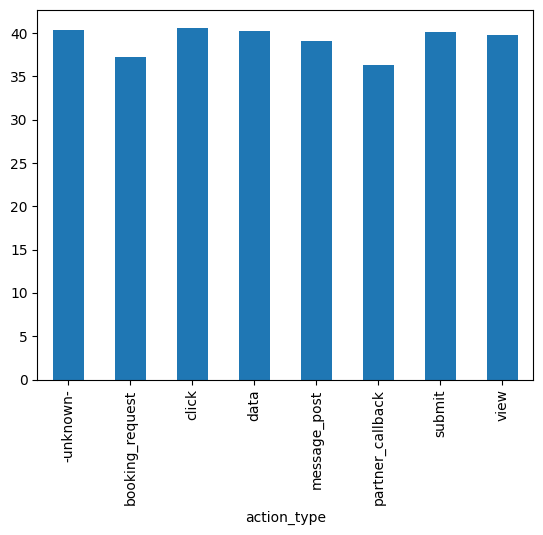

In [203]:
merged = tables["child"].merge(tables["parent"][["user_id", "age"]], on="user_id", how="left")
rtf_merged = rtf_tables["child"].merge(rtf_tables["parent"][["user_id", "age"]], on="user_id", how="left")
sdv_merged = sdv_tables["child"].merge(sdv_tables["parent"][["user_id", "age"]], on="user_id", how="left")

<AxesSubplot: ylabel='device_type'>

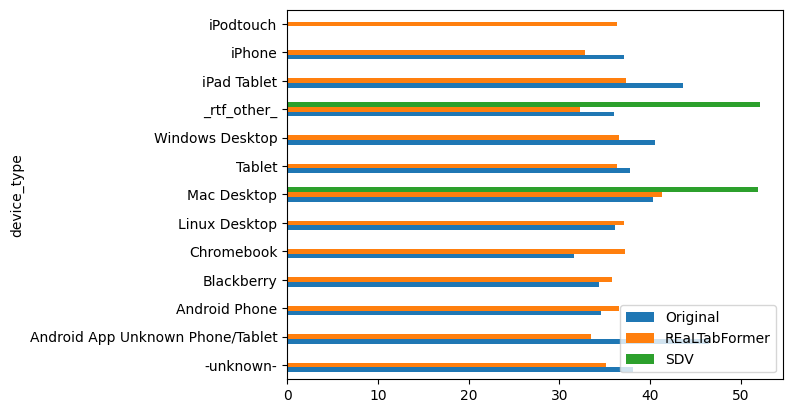

In [217]:
comp_df = pd.DataFrame()
# group_col = "action_type"
group_col = "device_type"
comp_df["Original"] = merged.groupby(group_col)["age"].mean().sort_index()
comp_df["REaLTabFormer"] = rtf_merged.groupby(group_col)["age"].mean().sort_index()
comp_df["SDV"] = sdv_merged.groupby(group_col)["age"].mean().sort_index()

comp_df.plot(kind="barh")

In [232]:
import seaborn as sns

In [271]:
def normalize_group(merged_df, ref_matrix, group_col, agg_col):
    u = pd.DataFrame(index=ref_matrix.index, columns=ref_matrix.columns)
    _u = merged_df.groupby(group_col)[agg_col].value_counts(normalize=True).unstack(level=1)

    u.loc[_u.index, :] = _u
    u = u.fillna(0)
    
    return u


bins = np.arange(20, 110, 10)
labels = [f"{i}-{i + 10}" if i < 90 else f"{i}+" for i in np.arange(20, 110, 10)][:-1]

merged["age_group"] = pd.cut(merged["age"], bins=bins, labels=labels)
rtf_merged["age_group"] = pd.cut(rtf_merged["age"], bins=bins, labels=labels)
sdv_merged["age_group"] = pd.cut(sdv_merged["age"], bins=bins, labels=labels)


orig_group = merged.groupby(group_col)["age_group"].value_counts(normalize=True).unstack(level=1)
rtf_group = normalize_group(rtf_merged, orig_group, group_col, agg_col="age_group")
sdv_group = normalize_group(sdv_merged, orig_group, group_col, agg_col="age_group")

In [304]:
orig_group.rename(index={"Android App Unknown Phone/Tablet": "Android App\nUnknown Phone/Tablet"})

age_group,20-30,30-40,40-50,50-60,60-70,70-80,80-90,90+
device_type,,,,,,,,
-unknown-,0.453950,0.300103,0.121421,0.068644,0.044153,0.011038,0.000000,0.000690
Android App\nUnknown Phone/Tablet,0.489787,0.339991,0.113482,0.039492,0.004539,0.012710,0.000000,0.000000
Android Phone,0.475836,0.304833,0.153903,0.059480,0.002230,0.000000,0.003717,0.000000
Blackberry,0.204545,0.568182,0.227273,0.000000,0.000000,0.000000,0.000000,0.000000
Chromebook,0.455056,0.424157,0.115169,0.000000,0.005618,0.000000,0.000000,0.000000
Linux Desktop,0.648241,0.326633,0.000000,0.025126,0.000000,0.000000,0.000000,0.000000
Mac Desktop,0.425073,0.323589,0.143414,0.074398,0.025484,0.006439,0.000000,0.001602
Tablet,0.435940,0.216306,0.221298,0.094842,0.028286,0.003328,0.000000,0.000000
Windows Desktop,0.380829,0.340613,0.125290,0.093377,0.046944,0.009247,0.003699,0.000000


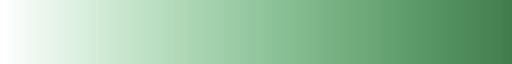

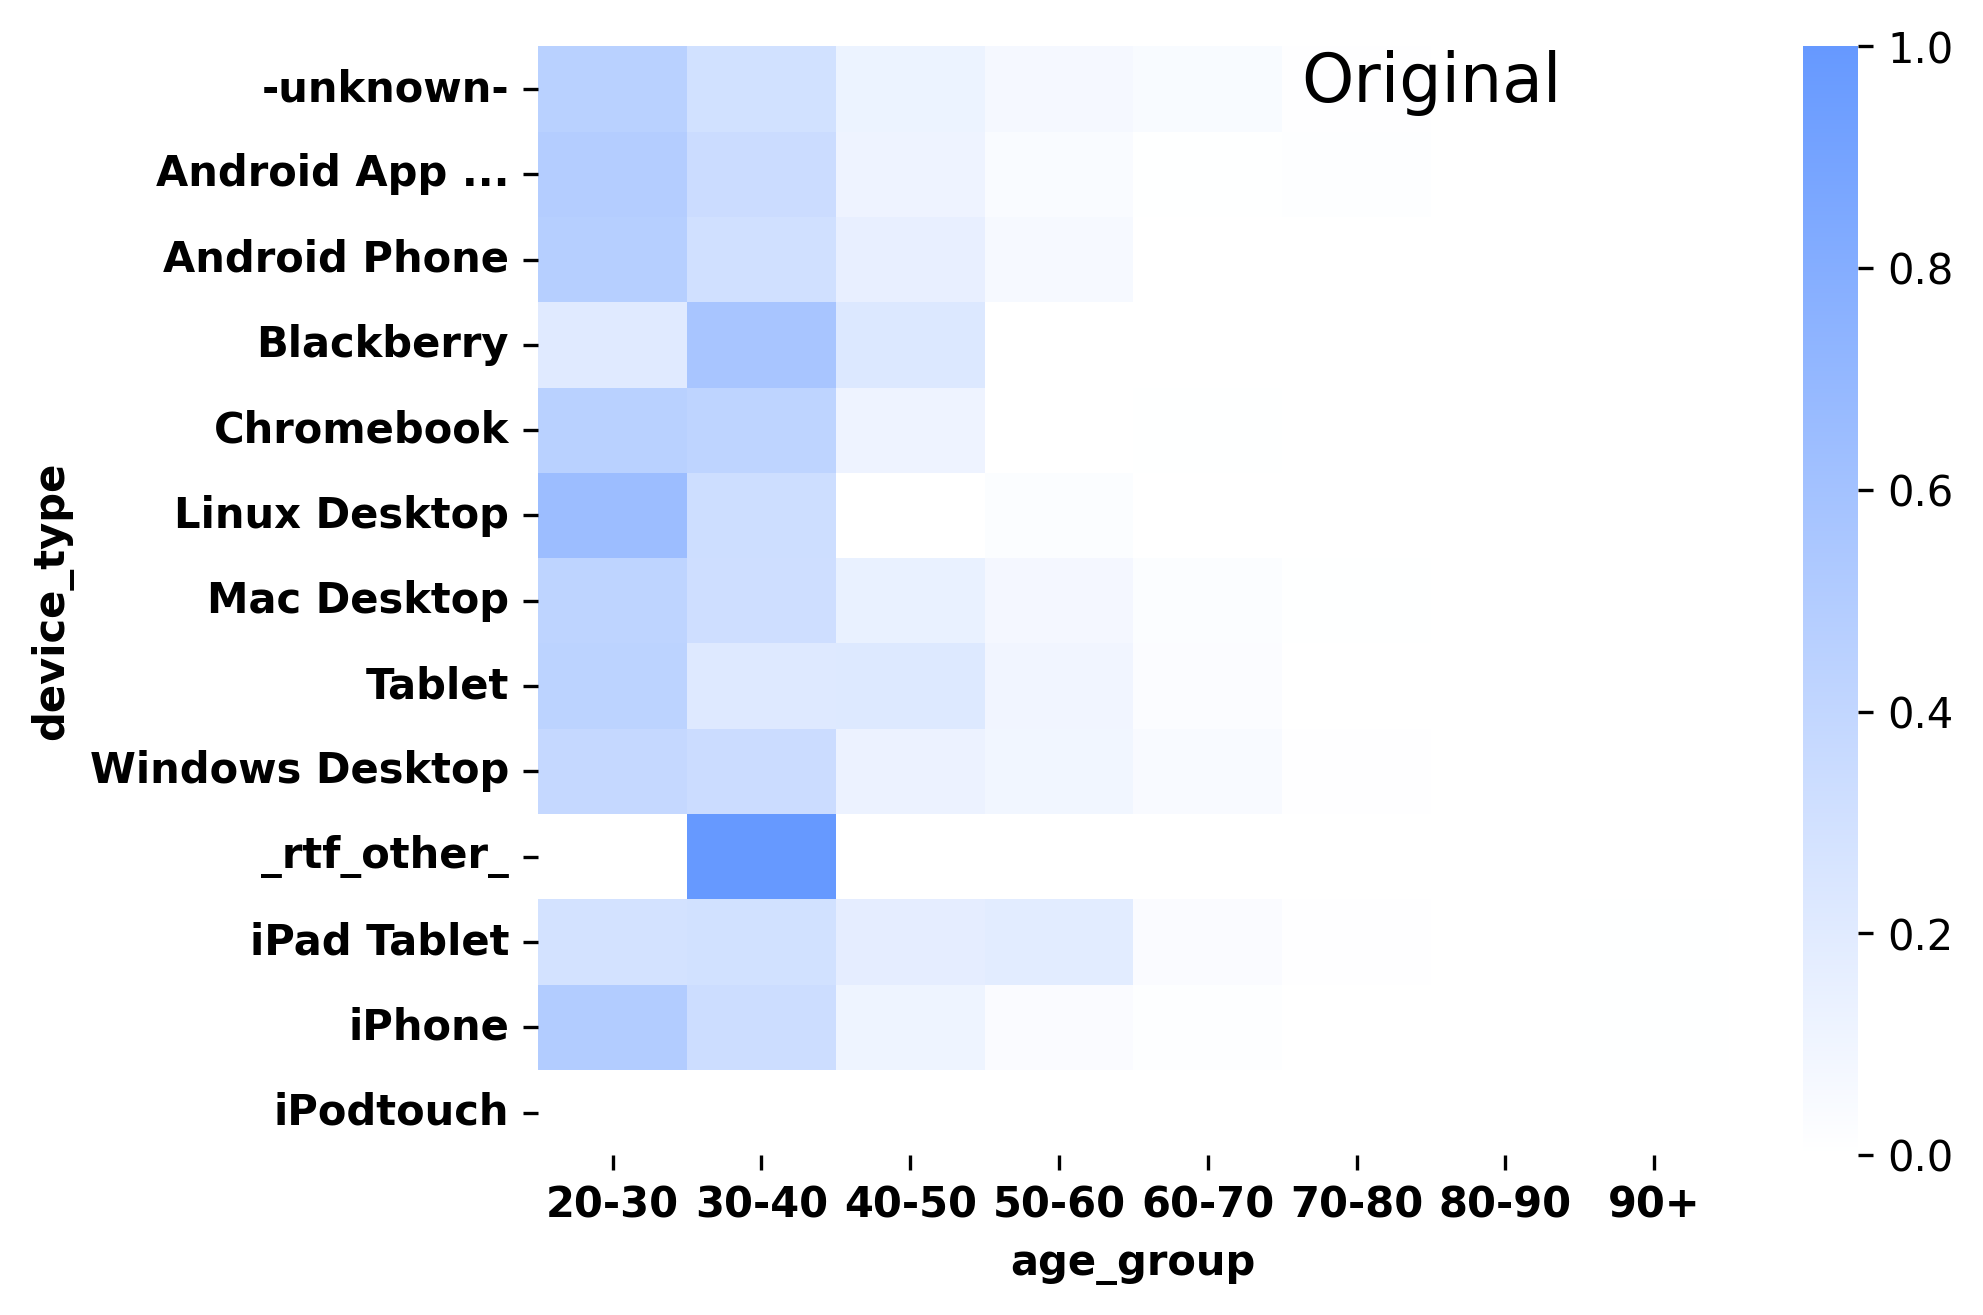

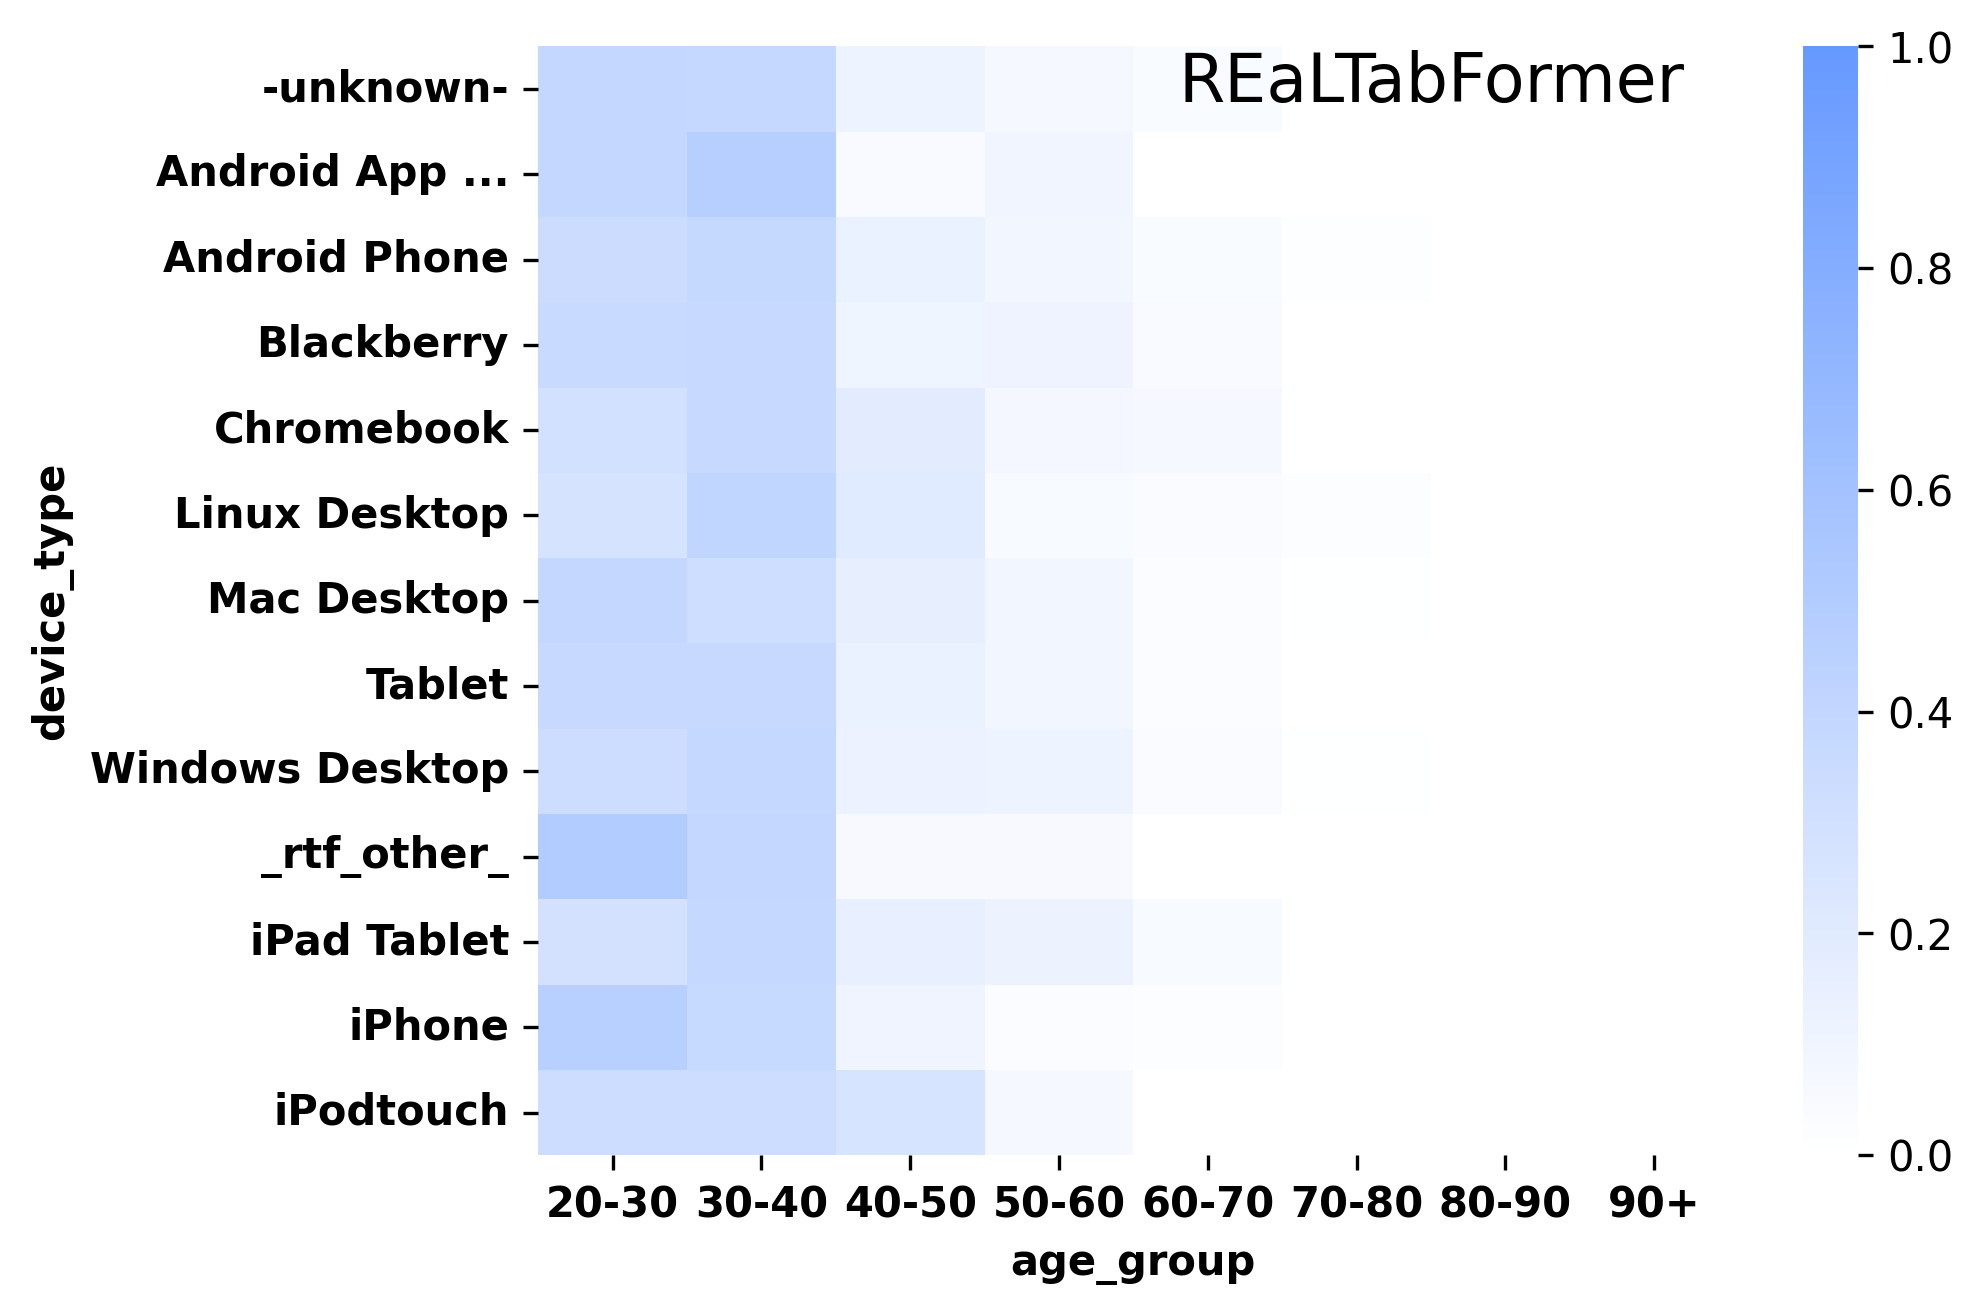

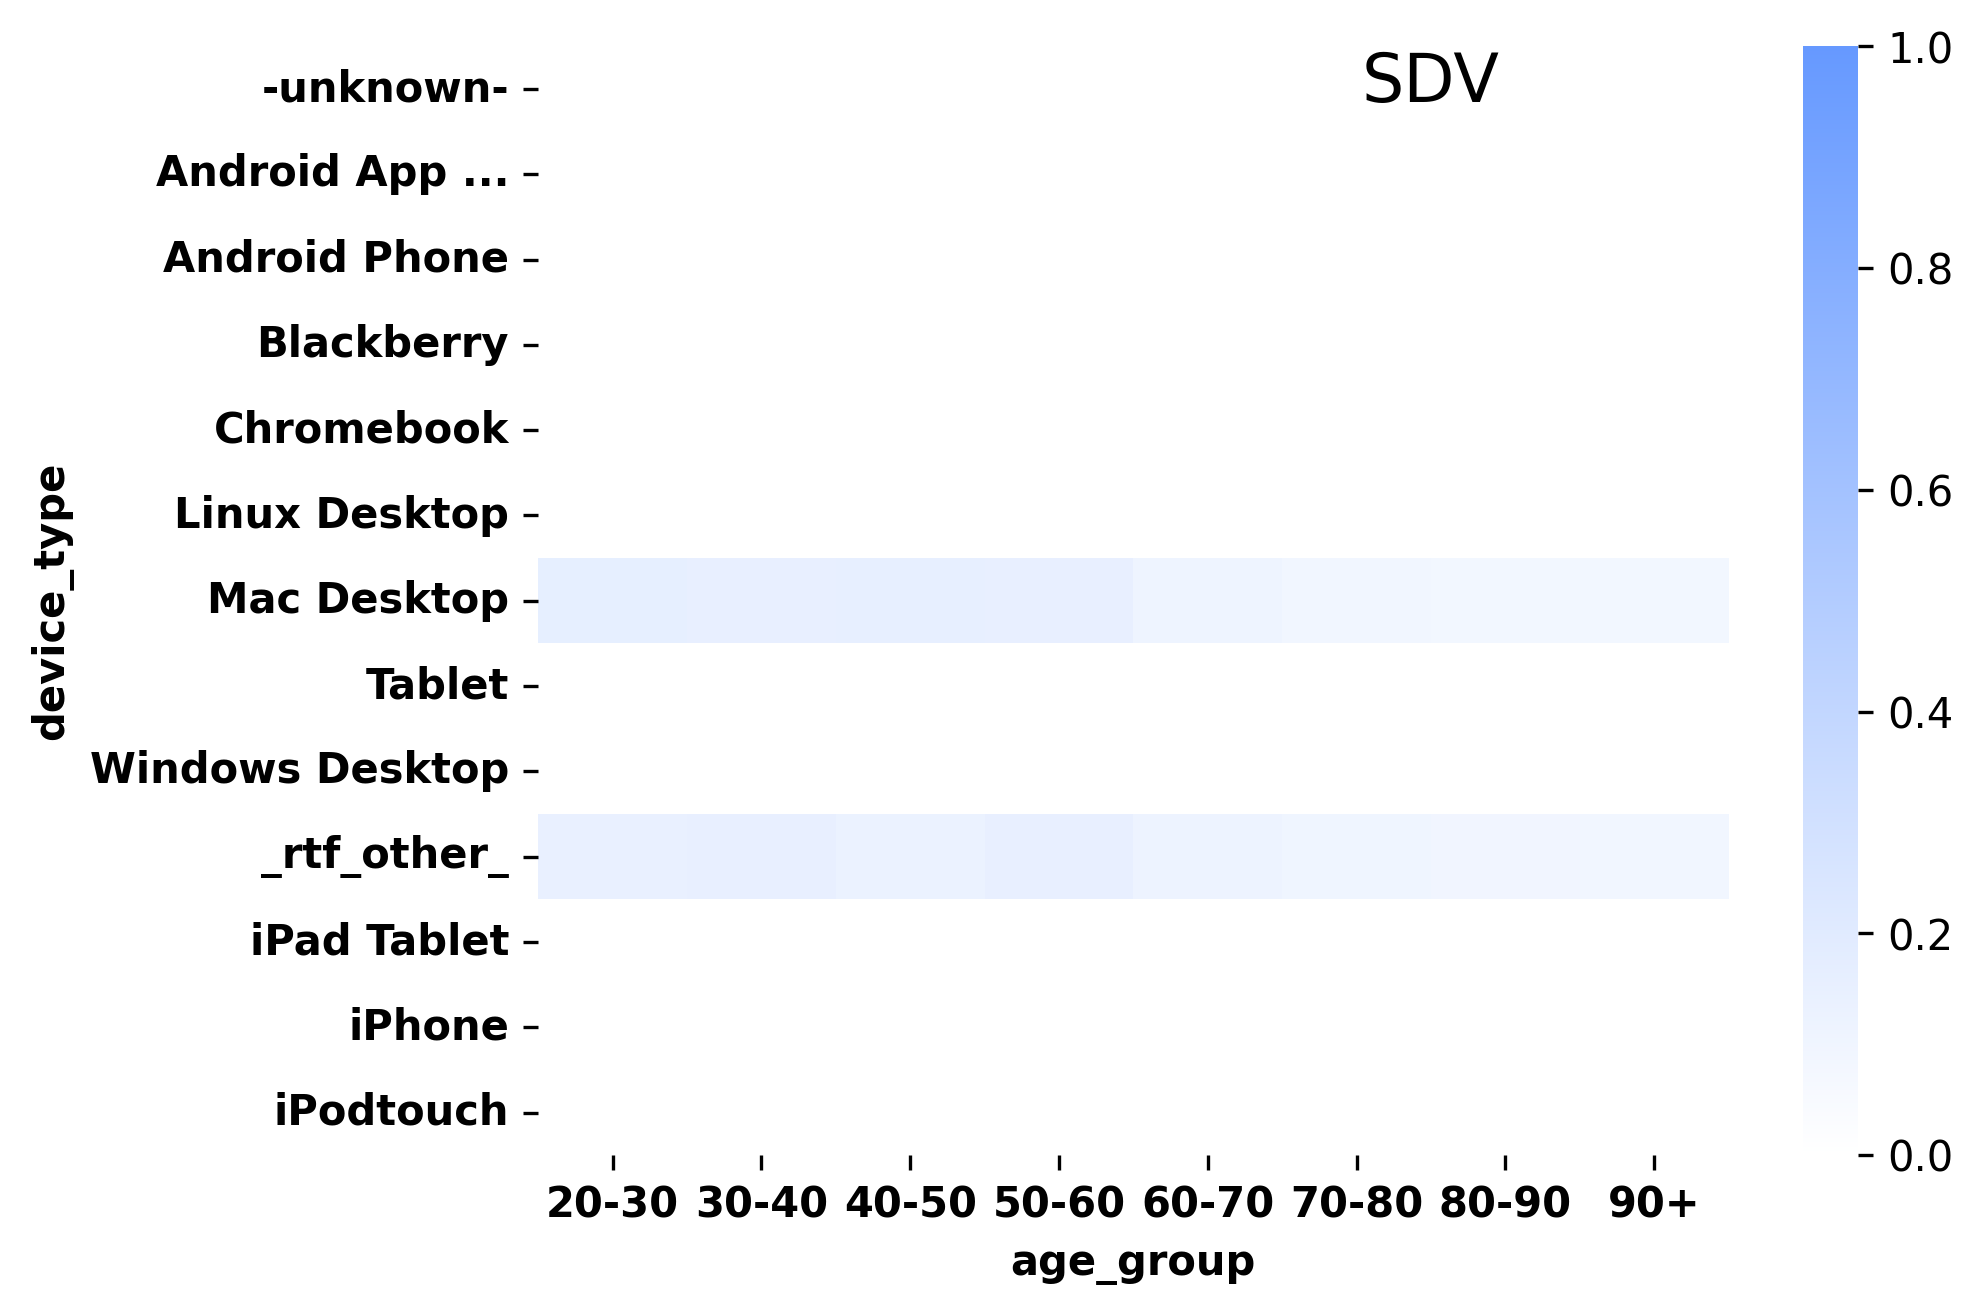

In [360]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.4, light=1, as_cmap=True)
# cmap = sns.color_palette("light:b", as_cmap=True)
# cmap = sns.light_palette("#69f", as_cmap=True)
cmap = LinearSegmentedColormap.from_list('', ['#fff', '#69f'])

model_id_group = dict(real=orig_group, rtf=rtf_group, sdv=sdv_group)
model_id_name = dict(real="Original", rtf="REaLTabFormer", sdv="SDV")

for model_id, group in model_id_group.items():
    name = model_id_name[model_id]

    fig = plt.figure(dpi=300)
    ax = fig.gca()
    ax = sns.heatmap(group, vmin=0, vmax=1, cmap=cmap, ax=ax)

    MAX_LABEL_LEN = 15
    labels = ax.get_yticklabels()

    for v in labels:
        text = v.get_text()
        if len(text) > MAX_LABEL_LEN:
            text = text[:MAX_LABEL_LEN - 3] + "..."

        v.set_text(text)

    ax.set_yticklabels(labels, fontweight="bold")
    ax.set_xticklabels(ax.get_xticklabels(), fontweight="bold")
    
    ax.set_xlabel(ax.get_xlabel(), fontweight="bold")
    ax.set_ylabel(ax.get_ylabel(), fontweight="bold")

    ax.text(0.75, 0.95, name, transform=ax.transAxes, fontsize=16, horizontalalignment="center")

    plt.savefig(PROJ_DIR / f"imgs/airbnb/AIRBNB_device_type-age_group_{model_id}.pdf", dpi=600, bbox_inches = "tight")
    # plt.close(fig)

In [54]:
tables["parent"]["n_sessions"].mean()

19.3178

In [59]:
tables["child"]

,user_id,action,action_type,action_detail,device_type,secs_elapsed
315,xwxei6hdk4,dashboard,view,dashboard,iPhone,1355.0
316,xwxei6hdk4,header_userpic,data,header_userpic,iPhone,1246.0
317,xwxei6hdk4,NaN,message_post,message_post,iPad Tablet,NaN
318,xwxei6hdk4,ask_question,submit,contact_host,iPad Tablet,386.0
319,xwxei6hdk4,ask_question,submit,contact_host,iPad Tablet,424.0
...,...,...,...,...,...,...
5550764,5fonl30j7c,reviews,data,listing_reviews,-unknown-,72.0
5550765,5fonl30j7c,reviews,data,listing_reviews,-unknown-,867.0
5550766,5fonl30j7c,show,view,user_profile,-unknown-,1534.0
5550767,5fonl30j7c,show,view,p3,-unknown-,58.0


In [76]:
act = tables["child"]["action_detail"].value_counts()
act

-unknown-                      13087
view_search_results            10156
wishlist_content_update         6246
p3                              6093
header_userpic                  4711
                               ...  
email_wishlist_button              1
email_wishlist                     1
toggle_archived_thread             1
change_password                    1
user_friend_recommendations        1
Name: action_detail, Length: 115, dtype: int64

In [81]:
act[act < 100].sum()

1111

In [80]:
act.sum() * 0.05

4418.05

In [55]:
rtf_tables["parent"]["n_sessions"].mean()

19.246133333333333

In [61]:
rtf_tables["child"].nunique().sort_values()

action_type          8
device_type         13
action_detail      112
action             127
user_id           7500
secs_elapsed     54168
dtype: int64

In [62]:
tables["child"]

,user_id,action,action_type,action_detail,device_type,secs_elapsed
315,xwxei6hdk4,dashboard,view,dashboard,iPhone,1355.0
316,xwxei6hdk4,header_userpic,data,header_userpic,iPhone,1246.0
317,xwxei6hdk4,NaN,message_post,message_post,iPad Tablet,NaN
318,xwxei6hdk4,ask_question,submit,contact_host,iPad Tablet,386.0
319,xwxei6hdk4,ask_question,submit,contact_host,iPad Tablet,424.0
...,...,...,...,...,...,...
5550764,5fonl30j7c,reviews,data,listing_reviews,-unknown-,72.0
5550765,5fonl30j7c,reviews,data,listing_reviews,-unknown-,867.0
5550766,5fonl30j7c,show,view,user_profile,-unknown-,1534.0
5550767,5fonl30j7c,show,view,p3,-unknown-,58.0


In [ ]:
rtf_tables

In [ ]:
sdv_tables

In [ ]:
ld_report_data = []

RTF_SAMPLES = (AIRBNB_EXP / "rtf_samples")
SDV_SAMPLES = (AIRBNB_EXP / "sdv_samples")

for seed in range(5):
    SEED_RTF_SAMPLES = RTF_SAMPLES / f"sample_seed{seed}"
    SEED_SDV_SAMPLES = SDV_SAMPLES / f"sample_seed{seed}"

    rtf_tables = {}
    rtf_tables["parent"] = pd.read_csv(SEED_RTF_SAMPLES / "rtf_parent.csv")
    rtf_tables["child"] = pd.read_csv(SEED_RTF_SAMPLES / "rtf_child.csv")

    for dt_col in tables["parent"].select_dtypes(include="datetime").columns:
        rtf_tables["parent"][dt_col] = pd.to_datetime(rtf_tables["parent"][dt_col])

    for dt_col in tables["child"].select_dtypes(include="datetime").columns:
        rtf_tables["child"][dt_col] = pd.to_datetime(rtf_tables["child"][dt_col])

    rtf_tables["parent"] = rtf_tables["parent"][tables["parent"].columns]
    rtf_tables["child"] = rtf_tables["child"][tables["child"].columns]

    rtf_tables["parent"] = rtf_tables["parent"].astype(tables["parent"].dtypes)
    rtf_tables["child"] = rtf_tables["child"].astype(tables["child"].dtypes)

    sdv_tables = {}
    sdv_tables["parent"] = pd.read_csv(SEED_SDV_SAMPLES / "sdv_parent.csv")
    sdv_tables["child"] = pd.read_csv(SEED_SDV_SAMPLES / "sdv_child.csv")

    sdv_tables["parent"] = sdv_tables["parent"][tables["parent"].columns]
    sdv_tables["child"] = sdv_tables["child"][tables["child"].columns]

    sdv_tables["parent"] = sdv_tables["parent"].astype(tables["parent"].dtypes)
    sdv_tables["child"] = sdv_tables["child"].astype(tables["child"].dtypes)

    for ld_seed in range(10):
        print(seed, ld_seed)

        ld_report_data.append(dict(
            sample_seed=seed,
            ld_seed=ld_seed,
            data_id=data_id,
            stats=report_logistic(
                real_in=tables["parent"],
                real_out=tables["child"],
                rtf_in=rtf_tables["parent"],
                rtf_out=rtf_tables["child"],
                sdv_in=sdv_tables["parent"],
                sdv_out=sdv_tables["child"],
                join_on=join_on,
                seed=ld_seed,
                classifier=LD_CLASSIFIER,
            )
        ))

full_data = {}

rtf_parent_ld = []
rtf_child_ld = []
rtf_merged_ld = []

sdv_parent_ld = []
sdv_child_ld = []
sdv_merged_ld = []

for lrd in ld_report_data:
    rtf_parent_ld.append(lrd["stats"]["parent"]["rtf"])
    rtf_child_ld.append(lrd["stats"]["child"]["rtf"])
    rtf_merged_ld.append(lrd["stats"]["merged"]["rtf"])

    sdv_parent_ld.append(lrd["stats"]["parent"]["sdv"])
    sdv_child_ld.append(lrd["stats"]["child"]["sdv"])
    sdv_merged_ld.append(lrd["stats"]["merged"]["sdv"])

full_data["rtf_parent_ld_mean"] = np.mean(rtf_parent_ld)
full_data["rtf_parent_ld_std"] = np.std(rtf_parent_ld, ddof=1)

full_data["rtf_child_ld_mean"] = np.mean(rtf_child_ld)
full_data["rtf_child_ld_std"] = np.std(rtf_child_ld, ddof=1)

full_data["rtf_merged_ld_mean"] = np.mean(rtf_merged_ld)
full_data["rtf_merged_ld_std"] = np.std(rtf_merged_ld, ddof=1)


full_data["sdv_parent_ld_mean"] = np.mean(sdv_parent_ld)
full_data["sdv_parent_ld_std"] = np.std(sdv_parent_ld, ddof=1)

full_data["sdv_child_ld_mean"] = np.mean(sdv_child_ld)
full_data["sdv_child_ld_std"] = np.std(sdv_child_ld, ddof=1)

full_data["sdv_merged_ld_mean"] = np.mean(sdv_merged_ld)
full_data["sdv_merged_ld_std"] = np.std(sdv_merged_ld, ddof=1)

full_data["raw"] = ld_report_data

AIRBNB_LD_REPORT = AIRBNB_EXP / "ld_report_data.json"
AIRBNB_LD_REPORT.write_text(json.dumps(full_data))

LogisticDetection for parents
SDV: 0.06091419236667772
REaLTabFormer: 0.7660043011325705

LogisticDetection for children
SDV: 0.0
REaLTabFormer: 0.05715281907705483

LogisticDetection for merged
SDV: 2.467416815754575e-06
REaLTabFormer: 0.032497090638027415
0 5
LogisticDetection for parents
SDV: 0.05882975374051169
REaLTabFormer: 0.7584486061251134

LogisticDetection for children
SDV: 1.3652845431977312e-06
REaLTabFormer: 0.053432268970281194

LogisticDetection for merged
SDV: 4.879112109890116e-07
REaLTabFormer: 0.033317332154721435
0 6
LogisticDetection for parents
SDV: 0.06612398360793603
REaLTabFormer: 0.7642019874056402

LogisticDetection for children
SDV: 2.73551933671623e-06
REaLTabFormer: 0.05319559315279021

LogisticDetection for merged
SDV: 9.169995784930052e-07
REaLTabFormer: 0.034030157342986755
0 7
LogisticDetection for parents
SDV: 0.06642504523606829
REaLTabFormer: 0.7619963926542423

LogisticDetection for children
SDV: 0.0
REaLTabFormer: 0.05233226750386921

LogisticDet

In [210]:
# comp = pd.DataFrame()

# comp["Original"] = tables["child"].groupby("Date")["Sales"].mean()
# comp["REaLTabFormer"] = rtf_tables["child"].groupby("Date")["Sales"].mean()
# comp["SDV"] = sdv_tables["child"].groupby("Date")["Sales"].mean()

# comp = comp.sort_index()
# comp.index = pd.to_datetime(comp.index)

# fig = plt.figure(dpi=300)
# ax = fig.gca()
# comp.plot(ax=ax)
# ax.set_ylabel("Average sales")

# plt.savefig(PROJ_DIR / "imgs/rossmann/Date_Sales.pdf", dpi=600, bbox_inches="tight")

In [211]:
# sst_comp_df = [
#     tables["child"].merge(tables["parent"], on="Store").groupby("StoreType")["Sales"].mean().reset_index(),
#     rtf_tables["child"].merge(rtf_tables["parent"], on="Store").groupby("StoreType")["Sales"].mean().reset_index(),
#     sdv_tables["child"].merge(sdv_tables["parent"], on="Store").groupby("StoreType")["Sales"].mean().reset_index()
# ]

# sst_comp_df[0]["Data"] = "Original"
# sst_comp_df[1]["Data"] = "REaLTabFormer"
# sst_comp_df[2]["Data"] = "SDV"

# sst_comp_df = pd.concat(sst_comp_df)
# sst_comp_df

In [80]:
import seaborn as sns
import matplotlib as mpl

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

In [212]:
# fig = plt.figure(dpi=300)
# ax = fig.gca()
# ax = sns.barplot(data=sst_comp_df, x="StoreType", y="Sales", hue="Data", ax=ax)
# ax.set_xlabel(ax.get_xlabel(), fontsize=16)  # , fontweight="bold")
# ax.set_ylabel(ax.get_ylabel(), fontsize=16)  # , fontweight="bold")


# plt.setp(ax.get_legend().get_texts(), fontsize=12)
# plt.setp(ax.get_legend().get_title(), fontsize=12)

# plt.savefig(PROJ_DIR / "imgs/rossmann/StoreType_Sales.pdf", dpi=600, bbox_inches="tight")

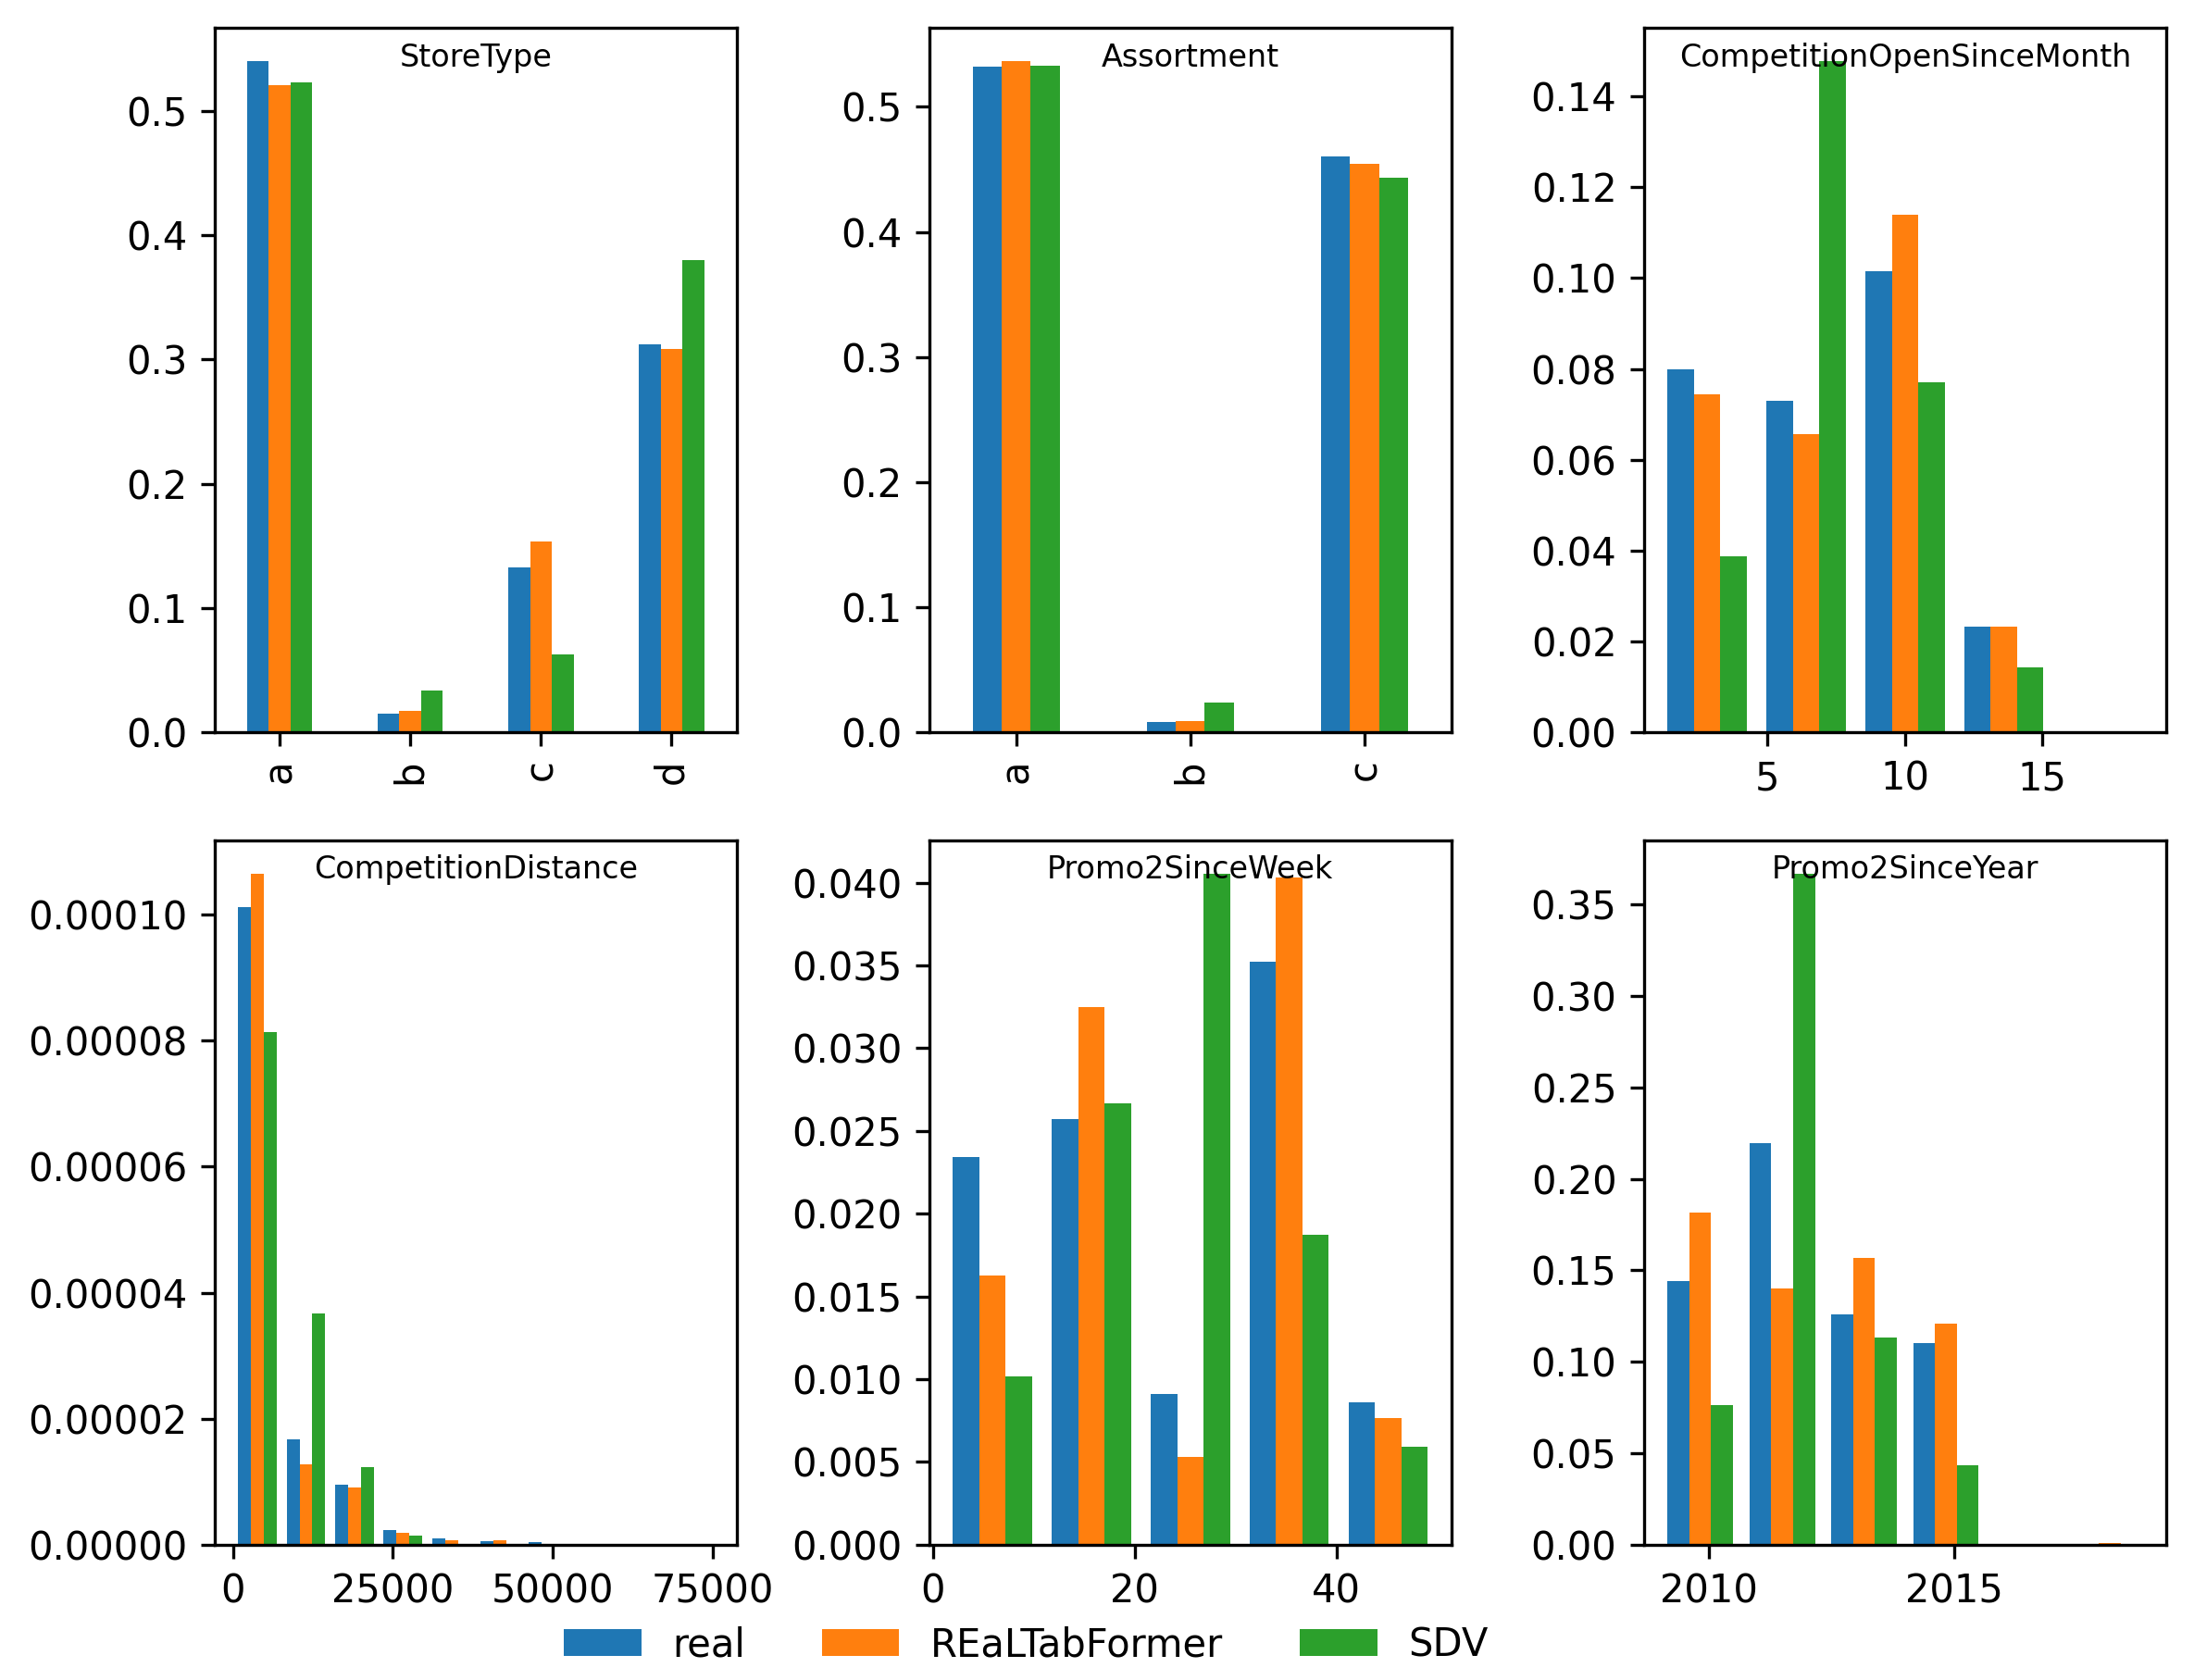

In [37]:
figure = plt.figure(figsize=(8, 6), dpi=300)
#########################################################
col = "StoreType"
comp = pd.DataFrame()

comp["real"] = raw_parent_df[col].value_counts(normalize=True, dropna=False)
comp["REaLTabFormer"] = rtf_parent_df[col].value_counts(normalize=True, dropna=False)
comp["SDV"] = sdv_parent_df[col].value_counts(normalize=True, dropna=False)
comp = comp.sort_index()

ax = plt.subplot(231)
comp.plot(kind="bar", ax=ax, legend=False)
# plt.legend(False)
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
col = "Assortment"
comp = pd.DataFrame()

comp["real"] = raw_parent_df[col].value_counts(normalize=True, dropna=False)
comp["REaLTabFormer"] = rtf_parent_df[col].value_counts(normalize=True, dropna=False)
comp["SDV"] = sdv_parent_df[col].value_counts(normalize=True, dropna=False)
comp = comp.sort_index()

ax = plt.subplot(232)
comp.plot(kind="bar", ax=ax, legend=False)
# plt.legend(False)
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
ax = plt.subplot(233)
col = "CompetitionOpenSinceMonth"
comp = pd.DataFrame()

comp["real"] = raw_parent_df[col].values
comp["REaLTabFormer"] = rtf_parent_df[col].values
comp["SDV"] = sdv_parent_df[col].values

n_bins = 5
colors = ['red', 'tan', 'lime']
ax.hist(comp, n_bins, density=True, histtype='bar')  # , label=comp.columns)
# ax.legend(prop={'size': 10})
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
ax = plt.subplot(234)

col = "CompetitionDistance"
# bins = np.linspace(in_df[col].min(), in_df[col].max(), 20)
# in_df[col].hist(bins=bins, density=True, label="real", ax=ax)
# parent_samples[col].hist(bins=bins, density=True, alpha=0.5, label="REaLTabFormer", ax=ax)
# sdv_store_samps[col].hist(bins=bins, density=True, alpha=0.5, label="SDV", ax=ax)
# ax.set_title(col)

comp = pd.DataFrame()

comp["real"] = raw_parent_df[col].values
comp["REaLTabFormer"] = rtf_parent_df[col].values
comp["SDV"] = sdv_parent_df[col].values

n_bins = 10
colors = ['red', 'tan', 'lime']
ax.hist(comp, n_bins, density=True, histtype='bar')  # , label=comp.columns)
# ax.legend(prop={'size': 10})
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
col = "Promo2SinceWeek"
ax = plt.subplot(235)
comp = pd.DataFrame()

comp["real"] = raw_parent_df[col].values
comp["REaLTabFormer"] = rtf_parent_df[col].values
comp["SDV"] = sdv_parent_df[col].values

n_bins = 5
colors = ['red', 'tan', 'lime']
ax.hist(comp, n_bins, density=True, histtype='bar')  # , label=comp.columns)
# ax.legend(prop={'size': 10})
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################
col = "Promo2SinceYear"
ax = plt.subplot(236)
comp = pd.DataFrame()

comp["real"] = raw_parent_df[col].values
comp["REaLTabFormer"] = rtf_parent_df[col].values
comp["SDV"] = sdv_parent_df[col].values

n_bins = 6
colors = ['red', 'tan', 'lime']
ax.hist(comp, n_bins, density=True, histtype='bar', label=comp.columns)
# ax.legend(prop={'size': 10})
ax.set_title(col, y=1.0, pad=-10, fontsize=8)
#########################################################


handles, labels = ax.get_legend_handles_labels()
# figure.legend(handles, labels, loc='lower center', ncol=5)
figure.legend(handles, labels, loc = (0.25, 0), ncol=5, frameon=False)


plt.tight_layout()

#### Compare the sessions per user_id

In [39]:
child_user_sessions = child_samples["user_id"].value_counts()
child_user_sessions

222    10
999     9
212     9
221     9
754     9
       ..
650     5
308     5
0       5
64      4
196     4
Name: user_id, Length: 1000, dtype: int64

In [40]:
parent_user_sessions = parent_samples[["user_id", "n_sessions"]].set_index("user_id")
parent_user_sessions

,n_sessions
user_id,
0,2
1,6
2,8
3,11
4,2
...,...
995,7
996,4
997,15


In [41]:
parent_user_sessions["child_sessions"] = child_user_sessions

In [47]:
(parent_user_sessions["n_sessions"] - parent_user_sessions["child_sessions"]).describe()

count    1000.000000
mean        1.229000
std         4.500312
min        -8.000000
25%        -2.000000
50%         1.000000
75%         4.000000
max        13.000000
dtype: float64

In [43]:
sdv_user_sessions = sdv_sessions_samps["user_id"].value_counts()
sdv_users_user_sessions = sdv_users_samps[["user_id", "n_sessions"]].set_index("user_id")
sdv_users_user_sessions["child_sessions"] = sdv_user_sessions
sdv_users_user_sessions

,n_sessions,child_sessions
user_id,,
a,15,15
b,2,2
c,14,14
d,5,5
e,15,15
...,...,...
sh,11,11
si,12,12
sj,3,3


In [44]:
(sdv_users_user_sessions["n_sessions"] == sdv_users_user_sessions["child_sessions"]).mean()

0.999

In [48]:
air_out_df.value_counts("action", normalize=True)

action
header_userpic       0.112201
show                 0.111510
create               0.083322
dashboard            0.056101
active               0.052784
                       ...   
ajax_image_upload    0.000138
recommendations      0.000138
friends              0.000138
signature            0.000138
11                   0.000138
Length: 138, dtype: float64

In [49]:
child_samples.value_counts("action", normalize=True)

action
dashboard            0.163913
header_userpic       0.159423
create               0.136006
active               0.099118
confirm_email        0.087410
                       ...   
trust                0.000160
ajax_statsd          0.000160
reviews_new          0.000160
apply_reservation    0.000160
referrer_status      0.000160
Length: 91, dtype: float64

In [50]:
sdv_sessions_samps.value_counts("action", normalize=True)

action
header_userpic    0.507829
supported         0.492171
dtype: float64

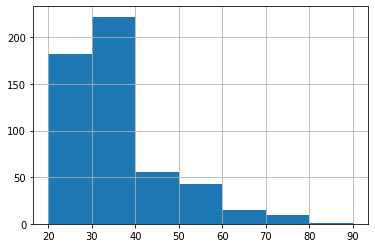

In [56]:
parent_samples["age"].hist(bins=range(20, 100, 10))

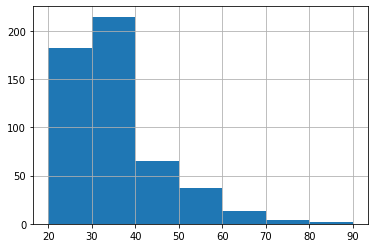

In [55]:
air_in_df["age"].hist(bins=range(20, 100, 10))

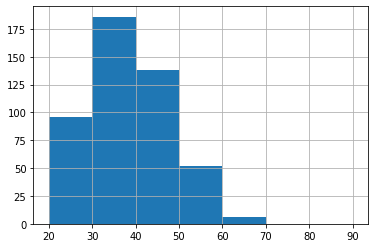

In [57]:
sdv_users_samps["age"].hist(bins=range(20, 100, 10))

In [58]:
sdv_sessions_samps["user_id"].value_counts().describe()

count    1000.000000
mean        7.792000
std         3.670723
min         2.000000
25%         5.000000
50%         8.000000
75%        10.000000
max        15.000000
Name: user_id, dtype: float64

In [59]:
air_out_df["user_id"].value_counts().describe()

count    1000.000000
mean        7.565000
std         4.136047
min         2.000000
25%         4.000000
50%         7.000000
75%        11.000000
max        15.000000
Name: user_id, dtype: float64

In [ ]:
parent_samples

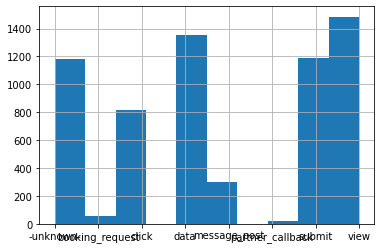

In [60]:
child_samples["action_type"].sort_values().hist()

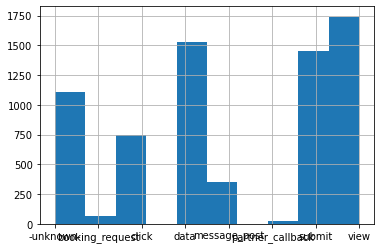

In [61]:
air_out_df["action_type"].sort_values().hist()

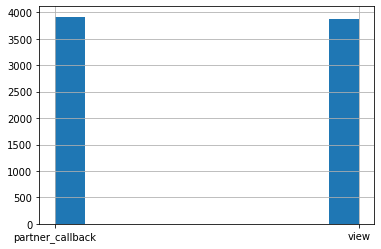

In [62]:
sdv_sessions_samps["action_type"].sort_values().hist()

In [48]:
len(air_out_df)

7565

In [51]:
child_samples["user_id"].value_counts().describe()

count    1000.000000
mean        3.332000
std         1.738044
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        14.000000
Name: user_id, dtype: float64

# Scratch